# 서울 집값 예측 프로젝트 

## 시나리오

In [6]:
# 한글폰트 관련 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


# 데이터 수집 관련 라이브러리 
import requests, bs4
from lxml import html
from urllib.request import Request, urlopen
from urllib.parse import urlencode, quote_plus, unquote

# 데이터분석 관련 라이브러리 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')
plt.rc('font', family='NanumBarunGothic') 
mpl.rc('axes', unicode_minus=False)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [9]:
cd drive/MyDrive/부동산프로젝트

/content/drive/MyDrive/부동산프로젝트


## 데이터 수집

###1) 기간, 법정동 코드

#### 수집연도 list 만들기

In [7]:
# YMD 리스트 준비하기 
#자리수에 0 넣어 숫자 출력 : "%02d" 에서 0 : 빈자리를 0으로 채운다, 2 : 2칸을 차지한다는 뜻입니다. 
'''
Format  Data   Result
%02d    1      01
%02d    11     11
'''

year = [str("%02d" %(y)) for y in range(2018, 2022)]
month = [str("%02d" %(m)) for m in range(1, 13)]
base_date_list = ["%s%s" %(y, m) for y in year for m in month ]
print(base_date_list)

['201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808', '201809', '201810', '201811', '201812', '201901', '201902', '201903', '201904', '201905', '201906', '201907', '201908', '201909', '201910', '201911', '201912', '202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012', '202101', '202102', '202103', '202104', '202105', '202106', '202107', '202108', '202109', '202110', '202111', '202112']


#### 법정동 5자리 코드 만들기

공공데이터포털에서 아파트 실거래 api는 법정동 5자리를 활용하여 데이터가 적재되어 있습니다. 이에, 법정동코드 전체자료를 공공데이터포털에서 별도로 받아 10자리의 법정동 코드를 5자리로 변경해주도록 하겠습니다. 인코딩은 utf-8로 사용하였습니다.  

In [8]:
# 데이터 불러오기 
local_code_df = pd.read_csv("법정동코드 전체자료.txt", sep='\t', encoding="utf-8")
local_code_df.head(2)

,법정동코드,법정동명,폐지여부
0,1100000000,서울특별시,존재
1,1111000000,서울특별시 종로구,존재


In [9]:
# 결측치 여부 확인 
local_code_df.isnull().sum()

법정동코드    0
법정동명     0
폐지여부     0
dtype: int64

In [10]:
# 여러 feature 중에서 법정동코드, 법정동명, 존재하는 코드만 가져오도록 하겠습니다.
# feature name을 'five_code', 'name', 'is_exist'로 변경합니다. 
local_code_df.columns = ['five_code', 'name', 'is_exist']

# 존재하는 코드만 불러옵니다. 
local_code_df = local_code_df[local_code_df['is_exist'] == '존재']

# 전국의 데이터이므로 서울지역만 불러옵니다. 
local_code_df = local_code_df[local_code_df['name'].str.contains("서울")]

# int dtype이기에 str로 변경합니다. 
local_code_df["five_code"] = local_code_df["five_code"].apply(str)

# 첫번째 숫자부터 5번째 숫자까지 저장합니다.( 인덱스의 시작은 0부터이니 5까지 인덱싱을 합니다. )
local_code_df["five_code"] = local_code_df["five_code"].str[:5]

In [11]:
# 변경된 데이터를 확인합니다. 
local_code_df.head(3)

,five_code,name,is_exist
0,11000,서울특별시,존재
1,11110,서울특별시 종로구,존재
2,11110,서울특별시 종로구 청운동,존재


In [12]:
# 중복되는 코드를 제거하고 리스트로 변환합니다. 
local_code_list = local_code_df["five_code"].unique().tolist()
local_code_list.remove("11000")
print(local_code_list)

['11110', '11140', '11170', '11200', '11215', '11230', '11260', '11290', '11305', '11320', '11350', '11380', '11410', '11440', '11470', '11500', '11530', '11545', '11560', '11590', '11620', '11650', '11680', '11710', '11740']


In [13]:
# 구별 정보를 확인하기 위해 데이터를 split합니다. 
local_code_df = local_code_df[1:]
local_code_df["gu_info"] = local_code_df["name"].str.split(" ").str[1]

In [14]:
# 혹시 결측치가 있는지 확인합니다. 
local_code_df["gu_info"].isnull().sum()

0

In [15]:
# 지역코드와 구 정보를 별도의 df로 만듭니다. 
local_gu_info = local_code_df[["five_code", "gu_info"]].drop_duplicates()
local_gu_info.T

,1,94,179,229,332,342,399,422,503,508,548,573,597,673,716,737,765,806,810,913,937,975,1003,1072,1087
five_code,11110,11140,11170,11200,11215,11230,11260,11290,11305,11320,11350,11380,11410,11440,11470,11500,11530,11545,11560,11590,11620,11650,11680,11710,11740
gu_info,종로구,중구,용산구,성동구,광진구,동대문구,중랑구,성북구,강북구,도봉구,노원구,은평구,서대문구,마포구,양천구,강서구,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구


In [16]:
# object dtypes인 five_code를 house_df 지역코드와 types을 일치시켜주기 위해 int로 변경합니다. 
local_gu_info["five_code"] = pd.to_numeric(local_gu_info["five_code"])

###2) 집값데이터 

#### 직접 구현한 코드로 데이터 수집

In [ ]:
# 
def get_data(LAWD_CD, DEAL_YMD, page_number):
  xmlUrl = 'http://openapi.molit.go.kr/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTradeDev'
  My_API_Key = unquote("2EjilhlvWl5ZStgjgWD65QvyZbwJcM8rNi%2B6Hvfr5UnmgULLKPlGtKCASH9qL6AJrMwBAUZGDIhMXZgDfvkxyg%3D%3D") 
  # unquote : URL 인용(quoting) 함수는 특수 문자를 인용하고 비 ASCII 텍스트를 적절히 인코딩하여 프로그램 데이터를 취해서 URL 구성 요소로 안전하게 사용할 수 있도록 하는 데 중점을 둡니다.
  #           또한 해당 작업이 위의 URL 구문 분석 함수로 처리되지 않는 경우 URL 구성 요소의 내용에서 원래 데이터를 다시 만들기 위해 이러한 작업을 뒤집는 것도 지원합니다.

  # 인증키와 필수 파라미터를 한번에 쓰면 코드가 읽기 힘드니, 이렇게 분리하여 dict형식으로 전환하여 줍니다. 
  queryParams = '?' + urlencode(    # get 방식으로 쿼리를 분리하기 위해 '?'를 넣은 것입니다. 메타코드 아닙니다. 
      {
        quote_plus('ServiceKey') : My_API_Key, # 필수 항목 1 : 서비스키 (본인의 서비스키)
        quote_plus('LAWD_CD') : LAWD_CD,          # 필수 항목 2 : 지역코드 (법정코드목록조회에서 확인)
        quote_plus('DEAL_YMD') : DEAL_YMD,        # 픽수 항목 3 : 계약월
        quote_plus('pageNo') : page_number,
        quote_plus('numOfRows') : 100000,
      }
  )

  # requests.get(xmlUrl + queryParams)만 입력하면 200이 나오고 
  # text를 가져오고 싶으면 당연히 .text를 해야하고 인코딩 방식은 당연히 utf-8로 진행합니다. 
  response = requests.get(xmlUrl + queryParams).text.encode('utf-8')
  xmlobj = bs4.BeautifulSoup(response, 'lxml-xml')
  
  return xmlobj


In [ ]:
# 빈데이터 프레임을 생성하여, for문을 돌고 난 후 생성된 dataframe을 이곳에 합쳐줍니다. 
results = pd.DataFrame()
none_data_info = []

# 이렇게 돌리면, 정상적으로 작동은 하나, 일일 가용 트래픽이 1000이므로, 중간에 멈추게 됩니다. 
# 이에, 연도를 2018, 2019, 2020, 2021로 나누어서 별도로 진행해야 합니다. 
for page in range(1, 5):
  print(f"총 4페이지 중 {page} page 출력하겠습니다.")
  for local_code in local_code_list:
    for base_date in base_date_list:
      xmlobj= get_data(local_code, base_date, page)
      rows = xmlobj.findAll('item')
      if rows != []:
        print(f"LAWD_CD:{local_code}, DEAL_YMD:{base_date} 데이터를 조회합니다.")
        columns = rows[0].find_all()

        rowList = []
        nameList = []
        columnList = []

        rowsLen = len(rows)
        for i in range(0, rowsLen):
          columns = rows[i].find_all()
          
          columnsLen = len(columns)
          for j in range(0, columnsLen):
            # 첫 번째 행 데이터 값 수집 시에만 컬럼 값을 저장한다. (어차피 rows[0], rows[1], ... 모두 컬럼헤더는 동일한 값을 가지기 때문에 매번 반복할 필요가 없습니다.)
            if i == 0:
                nameList.append(columns[j].name)
            # 컬럼값은 모든 행의 값을 저장해야합니다.    
            eachColumn = columns[j].text
            columnList.append(eachColumn)
          rowList.append(columnList)
          columnList = []    # 다음 row의 값을 넣기 위해 비워줍니다.
            
        result = pd.DataFrame(rowList, columns=nameList)
        results = results.append(result)
      else:
        none_data_info.append([page, local_code, base_date])
      

총 4페이지 중 1 page 출력하겠습니다.
LAWD_CD:11110, DEAL_YMD:201801 데이터를 조회합니다.
LAWD_CD:11110, DEAL_YMD:201802 데이터를 조회합니다.
LAWD_CD:11110, DEAL_YMD:201803 데이터를 조회합니다.
LAWD_CD:11110, DEAL_YMD:201804 데이터를 조회합니다.
LAWD_CD:11110, DEAL_YMD:201805 데이터를 조회합니다.
LAWD_CD:11110, DEAL_YMD:201806 데이터를 조회합니다.
LAWD_CD:11110, DEAL_YMD:201807 데이터를 조회합니다.
LAWD_CD:11110, DEAL_YMD:201808 데이터를 조회합니다.
LAWD_CD:11110, DEAL_YMD:201809 데이터를 조회합니다.
LAWD_CD:11110, DEAL_YMD:201810 데이터를 조회합니다.
LAWD_CD:11110, DEAL_YMD:201811 데이터를 조회합니다.
LAWD_CD:11110, DEAL_YMD:201812 데이터를 조회합니다.
LAWD_CD:11140, DEAL_YMD:201801 데이터를 조회합니다.
LAWD_CD:11140, DEAL_YMD:201802 데이터를 조회합니다.
LAWD_CD:11140, DEAL_YMD:201803 데이터를 조회합니다.
LAWD_CD:11140, DEAL_YMD:201804 데이터를 조회합니다.
LAWD_CD:11140, DEAL_YMD:201805 데이터를 조회합니다.
LAWD_CD:11140, DEAL_YMD:201806 데이터를 조회합니다.
LAWD_CD:11140, DEAL_YMD:201807 데이터를 조회합니다.
LAWD_CD:11140, DEAL_YMD:201808 데이터를 조회합니다.
LAWD_CD:11140, DEAL_YMD:201809 데이터를 조회합니다.
LAWD_CD:11140, DEAL_YMD:201810 데이터를 조회합니다.
LAWD_CD:11140, DEAL_YMD:20181

#### 라이브러리를 활용한 데이터수집방법(참고용) 

해당 라이브러리는 총 4페이지에서 일부 데이터만 수집하기에 사용하기 부적합 하다 생각하여 참고용으로만 코드를 보관하겠습니다.

In [ ]:
!pip install PublicDataReader
!pip install PublicDataReader --upgrade
!pip install finance-datareader

In [ ]:
import PublicDataReader as pdr
print(pdr.__version__)
serviceKey = "2EjilhlvWl5ZStgjgWD65QvyZbwJcM8rNi%2B6Hvfr5UnmgULLKPlGtKCASH9qL6AJrMwBAUZGDIhMXZgDfvkxyg%3D%3D"

molit = pdr.Transaction(serviceKey)

In [ ]:
results_2018 = pd.DataFrame()

for local_code in local_code_list:
  df_sum = molit.DataCollector(molit.AptTrade, local_code, 201801, 201812)
  results_2018 = results_2018.append(df_sum)

In [ ]:
results_2019 = pd.DataFrame()

for local_code in local_code_list:
  df_sum = molit.DataCollector(molit.AptTrade, local_code, 201901, 201912)
  results_2019 = results_2019.append(df_sum)

print(results_2019.shape)


In [ ]:
results_2020 = pd.DataFrame()

for local_code in local_code_list:
  df_sum = molit.DataCollector(molit.AptTrade, local_code, 202001, 202012)
  results_2020 = results_2020.append(df_sum)
print(results_2020)

In [ ]:
results.지역코드.value_counts()

41135    1172
11110     123
Name: 지역코드, dtype: int64

In [ ]:
house_df = pd.concat([house_price_2018,house_price_2019,house_price_2020],axis=0)
house_df.to_csv("2018 ~ 2020년 집값 데이터", index=False)

#### 데이터 Reload

In [18]:
# 2018년 ~ 2020년 짒값데이터를 다시 불러올 수 없으므로 저장한 데이터를 불러옵니다. 
house_df = pd.read_csv("2018 ~ 2020년 집값 데이터")
house_df

,지역코드,법정동,거래일,아파트,지번,전용면적,층,건축년도,거래금액
0,11110,내수동,2018-01-13,경희궁의아침2단지,71,140.78,15,2004,130000
1,11110,내수동,2018-01-19,경희궁 파크팰리스,95,103.77,5,2003,96000
2,11110,내수동,2018-01-23,경희궁의아침3단지,72,123.13,10,2004,118000
3,11110,내수동,2018-01-30,세종로대우,167,66.96,13,1994,54500
4,11110,내수동,2018-01-31,세종로대우,167,76.66,11,1994,64000
...,...,...,...,...,...,...,...,...,...
240905,11740,천호동,2020-12-29,동아하이빌아파트,217-132,84.97,16,2000,87000
240906,11740,천호동,2020-12-30,코오롱상가아파트,410-100,56.40,8,1988,87500
240907,11740,천호동,2020-12-30,래미안강동팰리스,571,59.98,27,2017,116500
240908,11740,천호동,2020-12-30,미사 아름채 아파트,452-15,12.14,8,2020,23000


In [17]:
# 변경 여부 확인 
house_df.dtypes

지역코드      int64
법정동      object
거래일      object
아파트      object
지번       object
전용면적    float64
층         int64
건축년도      int64
거래금액      int64
dtype: object

In [19]:
house_df = house_df.dropna(axis=0)
house_df.isnull().sum()

지역코드    0
법정동     0
거래일     0
아파트     0
지번      0
전용면적    0
층       0
건축년도    0
거래금액    0
dtype: int64

#### 데이터 정제

In [20]:
# 자치구 feature 생성합니다. 
house_df["자치구"] = house_df["지역코드"].map(dict(zip(local_gu_info.five_code, local_gu_info.gu_info)))

In [21]:
house_df.head(2)

,지역코드,법정동,거래일,아파트,지번,전용면적,층,건축년도,거래금액,자치구
0,11110,내수동,2018-01-13,경희궁의아침2단지,71,140.78,15,2004,130000,종로구
1,11110,내수동,2018-01-19,경희궁 파크팰리스,95,103.77,5,2003,96000,종로구


In [22]:
house_df['거래일'] = pd.to_datetime(house_df['거래일'])

In [23]:
house_df['거래연도'] = house_df["거래일"].dt.year
house_df['거래연월'] = pd.to_datetime(house_df['거래일'],format='%m%Y', errors='coerce').dt.to_period('m')

In [24]:
house_df.head(2)

,지역코드,법정동,거래일,아파트,지번,전용면적,층,건축년도,거래금액,자치구,거래연도,거래연월
0,11110,내수동,2018-01-13,경희궁의아침2단지,71,140.78,15,2004,130000,종로구,2018,2018-01
1,11110,내수동,2018-01-19,경희궁 파크팰리스,95,103.77,5,2003,96000,종로구,2018,2018-01


In [25]:
house_df.describe()

,지역코드,전용면적,층,건축년도,거래금액,거래연도
count,240819.000000,240819.000000,240819.000000,240819.000000,240819.000000,240819.000000
mean,11451.040885,77.929725,9.117379,2000.237033,77432.109099,2019.010975
std,172.668352,30.418615,6.167128,9.635244,54711.047905,0.829586
min,11110.000000,10.020000,-3.000000,1961.000000,5400.000000,2018.000000
25%,11320.000000,59.720000,4.000000,1994.000000,42800.000000,2018.000000
50%,11440.000000,83.400000,8.000000,2001.000000,63000.000000,2019.000000
75%,11590.000000,84.970000,13.000000,2007.000000,92000.000000,2020.000000
max,11740.000000,395.060000,69.000000,2021.000000,840000.000000,2020.000000


In [26]:
house_df.info()
house_df.isnull().sum().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240819 entries, 0 to 240909
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   지역코드    240819 non-null  int64         
 1   법정동     240819 non-null  object        
 2   거래일     240819 non-null  datetime64[ns]
 3   아파트     240819 non-null  object        
 4   지번      240819 non-null  object        
 5   전용면적    240819 non-null  float64       
 6   층       240819 non-null  int64         
 7   건축년도    240819 non-null  int64         
 8   거래금액    240819 non-null  int64         
 9   자치구     240819 non-null  object        
 10  거래연도    240819 non-null  int64         
 11  거래연월    240819 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), int64(5), object(4), period[M](1)
memory usage: 23.9+ MB


지역코드    0
법정동     0
거래일     0
아파트     0
지번      0
전용면적    0
층       0
건축년도    0
거래금액    0
자치구     0
거래연도    0
거래연월    0
dtype: int64

In [27]:
house_df["거래연월"].unique()

<PeriodArray>
['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
 '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
 '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09',
 '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04',
 '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11',
 '2020-12']
Length: 36, dtype: period[M]

###3) 주식데이터

In [64]:
KOREA = ['KS11', 'KQ11']
USA = ['DJI','IXIC','VIX']
WORLD = ['CSI300','SSEC','DE30','FCHI']
FUTRUES = ['NG','GC','HG','CL']

In [ ]:
!pip install finance-datareader

In [80]:
import FinanceDataReader as fdr
al_idx = fdr.DataReader('KS11', '2018', '2021').index
al_idx # 한국시장이 열리는 날들을 기준

stock_kr = pd.DataFrame(index=al_idx)
for kr in KOREA :
  stock_kr[kr] =  fdr.DataReader(kr, '2018', '2021')["Close"]
stock_kr.head()

,KS11,KQ11
Date,,
2018-01-02,2479.65,812.45
2018-01-03,2486.35,822.31
2018-01-04,2466.46,808.01
2018-01-05,2497.52,828.03
2018-01-08,2513.28,839.51


In [81]:
stock_us = pd.DataFrame(index=al_idx)
for us in USA :
  stock_us[us] =  fdr.DataReader(us, '2018', '2021')["Close"]
stock_us.head()

,DJI,IXIC,VIX
Date,,,
2018-01-02,24824.01,7006.9,9.77
2018-01-03,24922.68,7065.5,9.15
2018-01-04,25075.13,7077.9,9.22
2018-01-05,25295.87,7136.6,9.22
2018-01-08,25283.00,7157.4,9.52


In [82]:
stock_wo = pd.DataFrame(index=al_idx)
for wo in WORLD :
  stock_wo[wo] =  fdr.DataReader(wo, '2018', '2021')["Close"]
stock_wo.head()

,CSI300,SSEC,DE30,FCHI
Date,,,,
2018-01-02,4087.40,3348.33,12871.39,5288.60
2018-01-03,4111.39,3369.11,12978.21,5331.28
2018-01-04,4128.81,3385.71,13167.89,5413.69
2018-01-05,4138.75,3391.75,13319.64,5470.75
2018-01-08,4160.16,3409.48,13367.78,5487.42


In [83]:
stock_fu = pd.DataFrame(index=al_idx)
for fu in FUTRUES :
  stock_fu[fu] =  fdr.DataReader(fu, '2018', '2021')["Close"]
stock_fu.head()

,NG,GC,HG,CL
Date,,,,
2018-01-02,3.056,33.65,3.3630,75.14
2018-01-03,3.008,33.83,3.3500,74.85
2018-01-04,2.880,33.80,3.3565,75.33
2018-01-05,2.795,33.86,3.3275,75.42
2018-01-08,2.835,33.88,3.3225,75.53


In [84]:
stock_kr.shape,stock_us.shape,stock_wo.shape,stock_fu.shape

((738, 2), (738, 3), (738, 4), (738, 4))

In [85]:
stock_df=pd.concat([stock_kr,stock_us,stock_wo,stock_fu],axis=1)
stock_df.head(2)

,KS11,KQ11,DJI,IXIC,VIX,CSI300,SSEC,DE30,FCHI,NG,GC,HG,CL
Date,,,,,,,,,,,,,
2018-01-02,2479.65,812.45,24824.01,7006.9,9.77,4087.40,3348.33,12871.39,5288.60,3.056,33.65,3.363,75.14
2018-01-03,2486.35,822.31,24922.68,7065.5,9.15,4111.39,3369.11,12978.21,5331.28,3.008,33.83,3.350,74.85


In [86]:
stock_checking = pd.DataFrame()
stock_checking["type"] = stock_df.dtypes
stock_checking["nuique"] = stock_df.nunique()
stock_checking["null"] = stock_df.isnull().sum() 
 
stock_checking.T

,KS11,KQ11,DJI,IXIC,VIX,CSI300,SSEC,DE30,FCHI,NG,GC,HG,CL
type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
nuique,734,727,715,703,590,702,700,723,725,573,618,550,592
null,0,0,22,22,19,33,33,15,8,21,24,90,22


In [87]:
stock_df = stock_df.ffill()[1:]
stock_df.isna().sum().to_frame().T

,KS11,KQ11,DJI,IXIC,VIX,CSI300,SSEC,DE30,FCHI,NG,GC,HG,CL
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [88]:
stock_df = stock_df.reset_index()
stock_df['거래연월'] = pd.to_datetime(stock_df['Date'],format='%m%Y', errors='coerce').dt.to_period('m')
stock_group_df = stock_df.groupby('거래연월').mean()
stock_group_df.head(2)

,KS11,KQ11,DJI,IXIC,VIX,CSI300,SSEC,DE30,FCHI,NG,GC,HG,CL
거래연월,,,,,,,,,,,,,
2018-01,2522.903810,875.31,25850.645238,7291.614286,11.080952,4254.521905,3462.191905,13289.680476,5492.20381,3.167429,35.101905,3.318405,75.536190
2018-02,2439.104444,863.64,24951.283333,7151.200000,22.638889,4047.877778,3280.151667,12466.063889,5258.44500,2.668556,34.428333,3.292833,70.189444


In [254]:
stock_group_df.index

PeriodIndex(['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
             '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
             '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
             '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
             '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
             '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12'],
            dtype='period[M]', name='거래연월', freq='M')

In [255]:
ls

'2018년 집값 데이터'              '외국인증권투자현황(수정본).csv'
'2018 ~ 2020년 집값 데이터'        region_code5.csv
'2019년 집값 데이터'               stock_df
'2020년 집값 데이터'              '서울시 월별 전입인구데이터.txt'
 소비자물가상승률.csv             '서울시 분기별 인구.txt'
'소비자물가상승률(수정본).csv'    '법정동코드 전체자료.txt'
 시장금리추이통계표.csv           '국내총생산 및 경제성장률.xls'
'시장금리추이통계표(수정본).csv'   외국인증권투자현황.xls


###4) 시장금리 데이터

In [257]:
market_interest_rate_df = pd.read_csv("시장금리추이통계표.csv").T

market_interest_rate_df.columns = market_interest_rate_df.iloc[0]
market_interest_rate_df = market_interest_rate_df[1:]
market_interest_rate_df.head(2)

Unnamed: 0,국고채 3년(평균),국고채 5년(평균),국고채 10년(평균),회사채 3년(평균),CD 91물(평균),"콜금리(1일물,평균)",기준금리
201801월,2.19,2.44,2.63,2.72,1.66,1.49,1.5
201802월,2.28,2.54,2.77,2.82,1.65,1.49,1.5


In [258]:
# index 확인하고, 201801~202012로 인덱스를 변경합니다. 
market_interest_rate_df.index, market_interest_rate_df.index[:-6]

(Index(['201801월', '201802월', '201803월', '201804월', '201805월', '201806월',
        '201807월', '201808월', '201809월', '201810월', '201811월', '201812월',
        '201901월', '201902월', '201903월', '201904월', '201905월', '201906월',
        '201907월', '201908월', '201909월', '201910월', '201911월', '201912월',
        '202001월', '202002월', '202003월', '202004월', '202005월', '202006월',
        '202007월', '202008월', '202009월', '202010월', '202011월', '202012월',
        '202101월', '202102월', '202103월', '202104월', '202105월', '202106월'],
       dtype='object'),
 Index(['201801월', '201802월', '201803월', '201804월', '201805월', '201806월',
        '201807월', '201808월', '201809월', '201810월', '201811월', '201812월',
        '201901월', '201902월', '201903월', '201904월', '201905월', '201906월',
        '201907월', '201908월', '201909월', '201910월', '201911월', '201912월',
        '202001월', '202002월', '202003월', '202004월', '202005월', '202006월',
        '202007월', '202008월', '202009월', '202010월', '202011월', '202012월'],
       dtype

In [259]:
market_interest_rate_df = market_interest_rate_df[:-6]

In [260]:
market_interest_rate_df.index = stock_group_df.index
market_interest_rate_df = market_interest_rate_df.reset_index()

market_interest_rate_df.dtypes

Unnamed: 0
거래연월           period[M]
국고채 3년(평균)        object
국고채 5년(평균)        object
국고채 10년(평균)       object
회사채 3년(평균)        object
CD 91물(평균)        object
콜금리(1일물,평균)       object
기준금리              object
dtype: object

In [273]:
market_interest_rate_df = market_interest_rate_df.set_index(market_interest_rate_df["거래연월"])
market_interest_rate_df.head(2)

Unnamed: 0,거래연월,국고채 3년(평균),국고채 5년(평균),국고채 10년(평균),회사채 3년(평균),CD 91물(평균),"콜금리(1일물,평균)",기준금리
거래연월,,,,,,,,
2018-01,2018-01,2.19,2.44,2.63,2.72,1.66,1.49,1.5
2018-02,2018-02,2.28,2.54,2.77,2.82,1.65,1.49,1.5


###5) 소비자물가상률 데이터 

In [261]:
customer_inflation_rate_df = pd.read_csv("소비자물가상승률.csv", index_col=False)[0:8].T

customer_inflation_rate_df.columns = customer_inflation_rate_df.iloc[0]
customer_inflation_rate_df = customer_inflation_rate_df[1:]
customer_inflation_rate_df.head(2)

Unnamed: 0,소비자물가,- 농축수산물,- 공업제품,- 집세,- 공공서비스,- 개인서비스,근원물가,생활물가
201801월,0.8,-1.8,0.8,1.1,0.5,1.7,0.9,0.7
201802월,1.3,2.8,0.6,1,0.4,2.3,1.1,1.3


In [262]:
customer_inflation_rate_df.index

Index(['201801월', '201802월', '201803월', '201804월', '201805월', '201806월',
       '201807월', '201808월', '201809월', '201810월', '201811월', '201812월',
       '201901월', '201902월', '201903월', '201904월', '201905월', '201906월',
       '201907월', '201908월', '201909월', '201910월', '201911월', '201912월',
       '202001월', '202002월', '202003월', '202004월', '202005월', '202006월',
       '202007월', '202008월', '202009월', '202010월', '202011월', '202012월',
       '202101월', '202102월', '202103월', '202104월', '202105월', '202106월'],
      dtype='object')

In [263]:
customer_inflation_rate_df = customer_inflation_rate_df[:-6]

In [264]:
customer_inflation_rate_df.index = stock_group_df.index

### 6) 전입인구 데이터

In [265]:
transfer_population_df = pd.read_csv('서울시 월별 전입인구데이터.txt',sep='\t')[['기간','인구이동(전입지별)']].iloc[2:]
transfer_population_df["기간"] = transfer_population_df["기간"].str.replace(".", "-")
transfer_population_df = transfer_population_df.set_index("기간")
transfer_population_df.head(2)

,인구이동(전입지별)
기간,
2018-01,"119,120"
2018-02,"135,440"


In [266]:
transfer_population_df.index = stock_group_df.index

###7) 외국인증권투자 데이터

In [267]:
foreign_invest_df = pd.read_excel('외국인증권투자현황.xls')

foreign_invest_df = foreign_invest_df.iloc[:, 1:].T.loc[:,1].to_frame()
foreign_invest_df.columns = foreign_invest_df.iloc[0]
foreign_invest_df = foreign_invest_df[1:]
foreign_invest_df.head(2)

Unnamed: 1,유가증권시장
201801월,613.3
201802월,588.3


In [268]:
foreign_invest_df.index

Index(['201801월', '201802월', '201803월', '201804월', '201805월', '201806월',
       '201807월', '201808월', '201809월', '201810월', '201811월', '201812월',
       '201901월', '201902월', '201903월', '201904월', '201905월', '201906월',
       '201907월', '201908월', '201909월', '201910월', '201911월', '201912월',
       '202001월', '202002월', '202003월', '202004월', '202005월', '202006월',
       '202007월', '202008월', '202009월', '202010월', '202011월', '202012월',
       '202101월', '202102월', '202103월', '202104월', '202105월', '202106월'],
      dtype='object')

In [269]:
foreign_invest_df = foreign_invest_df[:-6]

In [270]:
foreign_invest_df.index = stock_group_df.index
foreign_invest_df.index

PeriodIndex(['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
             '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
             '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
             '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
             '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
             '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12'],
            dtype='period[M]', name='거래연월', freq='M')

## 데이터 병합

In [439]:
df = pd.concat([stock_group_df, market_interest_rate_df, customer_inflation_rate_df, transfer_population_df, foreign_invest_df], axis=1)
df.drop(columns=["거래연월"], inplace=True)
df = df.reset_index()
df.head()

,거래연월,KS11,KQ11,DJI,IXIC,VIX,CSI300,SSEC,DE30,FCHI,NG,GC,HG,CL,국고채 3년(평균),국고채 5년(평균),국고채 10년(평균),회사채 3년(평균),CD 91물(평균),"콜금리(1일물,평균)",기준금리,소비자물가,- 농축수산물,- 공업제품,- 집세,- 공공서비스,- 개인서비스,근원물가,생활물가,인구이동(전입지별),유가증권시장
0,2018-01,2522.903810,875.310000,25850.645238,7291.614286,11.080952,4254.521905,3462.191905,13289.680476,5492.203810,3.167429,35.101905,3.318405,75.536190,2.19,2.44,2.63,2.72,1.66,1.49,1.5,0.8,-1.8,0.8,1.1,0.5,1.7,0.9,0.7,"119,120",613.3
1,2018-02,2439.104444,863.640000,24951.283333,7151.200000,22.638889,4047.877778,3280.151667,12466.063889,5258.445000,2.668556,34.428333,3.292833,70.189444,2.28,2.54,2.77,2.82,1.65,1.49,1.5,1.3,2.8,0.6,1,0.4,2.3,1.1,1.3,"135,440",588.3
2,2018-03,2451.570000,867.919524,24558.081429,7305.919048,18.904762,4015.990476,3246.515714,12161.452857,5196.082857,2.701048,34.219048,3.198929,69.967143,2.27,2.5,2.71,2.83,1.65,1.49,1.5,1.2,1.2,0.8,0.9,0.4,2.6,1.3,1.1,"144,160",592.1
3,2018-04,2458.224762,879.889524,24304.212857,7084.138095,18.267619,3828.878095,3122.914762,12396.603810,5336.841905,2.724238,34.852381,3.236190,69.767619,2.19,2.44,2.66,2.79,1.65,1.47,1.5,1.5,3.5,1.3,0.8,0.3,2.6,1.4,1.5,"117,443",612.3
4,2018-05,2461.300500,863.840500,24602.901000,7356.235000,14.025000,3846.167500,3144.294500,12904.703500,5532.814500,2.836650,47.343000,3.208375,62.792000,2.25,2.53,2.76,2.86,1.65,1.5,1.5,1.5,1.7,1.5,0.6,0.2,2.8,1.3,1.5,"117,278",591.1


In [440]:
final_df = pd.merge(house_df, df, how="inner", on="거래연월")
final_df.head(2)

,지역코드,법정동,거래일,아파트,지번,전용면적,층,건축년도,거래금액,자치구,거래연도,거래연월,KS11,KQ11,DJI,IXIC,VIX,CSI300,SSEC,DE30,FCHI,NG,GC,HG,CL,국고채 3년(평균),국고채 5년(평균),국고채 10년(평균),회사채 3년(평균),CD 91물(평균),"콜금리(1일물,평균)",기준금리,소비자물가,- 농축수산물,- 공업제품,- 집세,- 공공서비스,- 개인서비스,근원물가,생활물가,인구이동(전입지별),유가증권시장
0,11110,내수동,2018-01-13,경희궁의아침2단지,71,140.78,15,2004,130000,종로구,2018,2018-01,2522.90381,875.31,25850.645238,7291.614286,11.080952,4254.521905,3462.191905,13289.680476,5492.20381,3.167429,35.101905,3.318405,75.53619,2.19,2.44,2.63,2.72,1.66,1.49,1.5,0.8,-1.8,0.8,1.1,0.5,1.7,0.9,0.7,"119,120",613.3
1,11110,내수동,2018-01-19,경희궁 파크팰리스,95,103.77,5,2003,96000,종로구,2018,2018-01,2522.90381,875.31,25850.645238,7291.614286,11.080952,4254.521905,3462.191905,13289.680476,5492.20381,3.167429,35.101905,3.318405,75.53619,2.19,2.44,2.63,2.72,1.66,1.49,1.5,0.8,-1.8,0.8,1.1,0.5,1.7,0.9,0.7,"119,120",613.3


In [441]:
final_df.shape

(240819, 42)

In [442]:
# 최종으로 완성된 파일 저장합니다.
final_df.to_csv("final_df.csv", index=False)

## 데이터 EDA

In [10]:
df = pd.read_csv("final_df.csv")
df = df.drop(columns=['거래일'])
df.head(2)

,지역코드,법정동,아파트,지번,전용면적,층,건축년도,거래금액,자치구,거래연도,거래연월,KS11,KQ11,DJI,IXIC,VIX,CSI300,SSEC,DE30,FCHI,NG,GC,HG,CL,국고채 3년(평균),국고채 5년(평균),국고채 10년(평균),회사채 3년(평균),CD 91물(평균),"콜금리(1일물,평균)",기준금리,소비자물가,- 농축수산물,- 공업제품,- 집세,- 공공서비스,- 개인서비스,근원물가,생활물가,인구이동(전입지별),유가증권시장
0,11110,내수동,경희궁의아침2단지,71,140.78,15,2004,130000,종로구,2018,2018-01,2522.90381,875.31,25850.645238,7291.614286,11.080952,4254.521905,3462.191905,13289.680476,5492.20381,3.167429,35.101905,3.318405,75.53619,2.19,2.44,2.63,2.72,1.66,1.49,1.5,0.8,-1.8,0.8,1.1,0.5,1.7,0.9,0.7,"119,120",613.3
1,11110,내수동,경희궁 파크팰리스,95,103.77,5,2003,96000,종로구,2018,2018-01,2522.90381,875.31,25850.645238,7291.614286,11.080952,4254.521905,3462.191905,13289.680476,5492.20381,3.167429,35.101905,3.318405,75.53619,2.19,2.44,2.63,2.72,1.66,1.49,1.5,0.8,-1.8,0.8,1.1,0.5,1.7,0.9,0.7,"119,120",613.3


In [27]:
df.shape

(240819, 43)

In [7]:
checking = pd.DataFrame()
checking["type"] = df.dtypes
checking["nuique"] = df.nunique()
checking["null"] = df.isnull().sum() 
 
checking.T

,지역코드,법정동,아파트,지번,전용면적,층,건축년도,거래금액,자치구,거래연도,거래연월,KS11,KQ11,DJI,IXIC,VIX,CSI300,SSEC,DE30,FCHI,NG,GC,HG,CL,국고채 3년(평균),국고채 5년(평균),국고채 10년(평균),회사채 3년(평균),CD 91물(평균),"콜금리(1일물,평균)",기준금리,소비자물가,- 농축수산물,- 공업제품,- 집세,- 공공서비스,- 개인서비스,근원물가,생활물가,인구이동(전입지별),유가증권시장
type,int64,object,object,object,float64,int64,int64,int64,object,int64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64
nuique,25,329,6844,5880,10829,71,58,4105,25,3,36,36,36,36,36,36,36,36,36,36,36,36,36,36,32,30,30,28,24,21,5,19,30,23,14,20,17,12,22,36,36
null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Feature engineering

In [8]:
df.tail(1)

,지역코드,법정동,아파트,지번,전용면적,층,건축년도,거래금액,자치구,거래연도,거래연월,KS11,KQ11,DJI,IXIC,VIX,CSI300,SSEC,DE30,FCHI,NG,GC,HG,CL,국고채 3년(평균),국고채 5년(평균),국고채 10년(평균),회사채 3년(평균),CD 91물(평균),"콜금리(1일물,평균)",기준금리,소비자물가,- 농축수산물,- 공업제품,- 집세,- 공공서비스,- 개인서비스,근원물가,생활물가,인구이동(전입지별),유가증권시장
240818,11740,천호동,금호아파트,44,27.61,5,1987,37800,강동구,2020,2020-12,2755.770952,928.019048,30126.775238,12606.22381,22.35619,5007.297143,3396.376667,13433.63,5546.606667,2.586429,39.274286,3.549619,85.081905,0.97,1.32,1.68,2.21,0.66,0.51,0.5,0.5,9.7,-0.9,0.7,-2.0,1.3,0.9,-0.1,"133,111",723.1


In [14]:
# 데이터를 다시 불러오면서 type이 변경된 feature이 있습니다. 
# 이를 다시 정정해주도록 하겠습니다. 
df["인구이동(전입지별)"] = df["인구이동(전입지별)"].str.replace(",","").astype(int)

### 새로운 feature 생성  


In [15]:
# 거래금액과 전용면적을 이용하여 평당 가격을 확인해보도록 하겠습니다. 
# 또한, 각각의 row가 한 개의 거래이므로 거래횟수라는 feature를 만들어주도록 하겠습니다. 

df['평단가'] = df['거래금액'] / df['전용면적']
df['거래횟수'] = 1
df.head(2)

,지역코드,법정동,아파트,지번,전용면적,층,건축년도,거래금액,자치구,거래연도,거래연월,KS11,KQ11,DJI,IXIC,VIX,CSI300,SSEC,DE30,FCHI,NG,GC,HG,CL,국고채 3년(평균),국고채 5년(평균),국고채 10년(평균),회사채 3년(평균),CD 91물(평균),"콜금리(1일물,평균)",기준금리,소비자물가,- 농축수산물,- 공업제품,- 집세,- 공공서비스,- 개인서비스,근원물가,생활물가,인구이동(전입지별),유가증권시장,평단가,거래횟수
0,11110,내수동,경희궁의아침2단지,71,140.78,15,2004,130000,종로구,2018,2018-01,2522.90381,875.31,25850.645238,7291.614286,11.080952,4254.521905,3462.191905,13289.680476,5492.20381,3.167429,35.101905,3.318405,75.53619,2.19,2.44,2.63,2.72,1.66,1.49,1.5,0.8,-1.8,0.8,1.1,0.5,1.7,0.9,0.7,119120,613.3,923.426623,1
1,11110,내수동,경희궁 파크팰리스,95,103.77,5,2003,96000,종로구,2018,2018-01,2522.90381,875.31,25850.645238,7291.614286,11.080952,4254.521905,3462.191905,13289.680476,5492.20381,3.167429,35.101905,3.318405,75.53619,2.19,2.44,2.63,2.72,1.66,1.49,1.5,0.8,-1.8,0.8,1.1,0.5,1.7,0.9,0.7,119120,613.3,925.122868,1


In [16]:
# 평단가가 가장 높은 곧은 어디인지 확인해보도록 하겠습니다. 
# 역시 가장 높은 지역은 강남구 였고, 강남 -> 강동 -> 강북 -> 강서 -> 관악 순으로 관측되었습니다. 

df[["법정동", "아파트", "자치구", "평단가"]].sort_values("평단가", ascending=False).groupby("자치구").sum().head(20)

,평단가
자치구,
강남구,2.351789e+07
강동구,1.235409e+07
강북구,3.722244e+06
강서구,1.257494e+07
관악구,5.935979e+06
광진구,4.937315e+06
구로구,9.124004e+06
금천구,2.987992e+06
노원구,1.794043e+07


In [17]:
# 거래 횟수를 이용하여 자치구별 랭킹을 매겨보도록 하겠습니다. 
rank = pd.concat([df.groupby('자치구').mean()[["평단가",'거래금액']].sort_values('거래금액',ascending=False),
                          df.groupby('자치구').sum()[['거래횟수']]],
                          axis = 1).sort_values("거래횟수", ascending=False)

rank.head(20)

,평단가,거래금액,거래횟수
자치구,,,
노원구,719.632300,45310.518652,24930
송파구,1416.986516,116817.008178,15040
강서구,853.406403,60720.017306,14735
구로구,692.629164,49678.507705,13173
성북구,765.792449,58597.555598,13112
강동구,1017.383567,74534.672980,12143
강남구,1960.150606,172381.659943,11998
도봉구,595.782907,40985.334089,11473
양천구,992.560950,79586.816031,11241


여기서 인사이트를 하나 발견하네요. 강북구, 관악구는 집값이 높은 것으로 위에서 관측되었습니다.   
그러나, 실제 거래는 많이 이루어지지 않는 것으로 관측이 되었습니다.  
의외의 지역(노원구, 송파구, 구로구, 성북구)에서 다수의 거래가 이루어지고 있습니다.   
아무래도 저평가 되었다고 생각하여 투기 세력이 몰리는 곳이 아닌지 검토해볼 필요가 있는 지역들입니다.


In [17]:
# 거래 횟수를 이용하여 법정동별 랭킹을 매겨보도록 하겠습니다. 
pd.concat([df.groupby('법정동').mean()[["평단가", '거래금액']].sort_values('거래금액',ascending=False),
                          df.groupby('법정동').sum()[['거래횟수']]],
                          axis = 1).sort_values("거래횟수", ascending=False).head(20)

,평단가,거래금액,거래횟수
상계동,723.982925,42345.257753,9738
중계동,737.250173,50727.450113,5743
구로동,681.896814,43478.898775,4979
신정동,1031.883663,80650.869733,4913
창동,733.338169,48171.658935,4527
봉천동,815.715421,58874.264568,4479
월계동,736.608237,46086.703600,3583
목동,1243.166241,107918.652661,3570
미아동,726.843552,55324.121406,3443
공릉동,654.773675,41331.873536,3416


In [18]:
# 거래 횟수를 이용하여 아파트별 랭킹을 매겨보도록 하겠습니다. 
pd.concat([df.groupby('아파트').mean()[["평단가", '거래금액','거래연도']].sort_values('거래금액',ascending=False),
                          df.groupby('아파트').sum()[['거래횟수']]],
                          axis = 1).sort_values("거래횟수", ascending=False).head(20)


,평단가,거래금액,거래연도,거래횟수
현대,843.569866,67189.813825,2018.980492,2358
두산,812.297302,60240.349030,2018.992798,1805
한신,734.314544,53126.343639,2019.029727,1682
신동아,1065.331480,81920.696053,2018.919737,1520
벽산,681.581936,49574.804845,2018.979139,1486
삼성래미안,1035.915377,88684.692792,2019.047586,1429
주공2,756.309211,35378.712595,2019.009298,1183
삼성,1068.556074,82570.461237,2019.037291,1019
대우,748.409955,51325.147348,2018.995088,1018
우성,1029.842000,78217.689906,2018.994797,961


아파트 관점에서 해당 데이터를 보았을 때는 현대와 두산, 한신이 고객분들로부터 신뢰를 받는 아파트가 아닌지 추측해 볼 수 있습니다.  
그 중 현대는 다른 아파트보다 거래 횟수가 유독 눈에 뜁니다. 

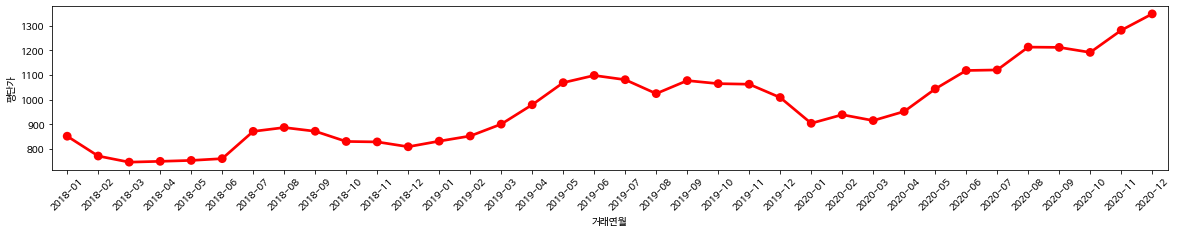

In [18]:
월별 = df.groupby(['거래연월']).mean()[['평단가','거래금액']].sort_values('거래연월',ascending=True).reset_index()
plt.figure(figsize=(20,3))
plt.xticks(rotation=45)
sns.pointplot(x='거래연월',y='평단가',data=월별,color='red');

In [20]:
df.groupby('거래연월').mean().iloc[:,3:].head()

,건축년도,거래금액,거래연도,KS11,KQ11,DJI,IXIC,VIX,CSI300,SSEC,DE30,FCHI,NG,GC,HG,CL,국고채 3년(평균),국고채 5년(평균),국고채 10년(평균),회사채 3년(평균),CD 91물(평균),"콜금리(1일물,평균)",기준금리,소비자물가,- 농축수산물,- 공업제품,- 집세,- 공공서비스,- 개인서비스,근원물가,생활물가,인구이동(전입지별),유가증권시장,평단가,거래횟수
거래연월,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01,2000.131296,70575.764462,2018.0,2522.903810,875.310000,25850.645238,7291.614286,11.080952,4254.521905,3462.191905,13289.680476,5492.203810,3.167429,35.101905,3.318405,75.536190,2.19,2.44,2.63,2.72,1.66,1.49,1.5,0.8,-1.8,0.8,1.1,0.5,1.7,0.9,0.7,119120.0,613.3,851.897151,1.0
2018-02,2000.571600,61516.091256,2018.0,2439.104444,863.640000,24951.283333,7151.200000,22.638889,4047.877778,3280.151667,12466.063889,5258.445000,2.668556,34.428333,3.292833,70.189444,2.28,2.54,2.77,2.82,1.65,1.49,1.5,1.3,2.8,0.6,1.0,0.4,2.3,1.1,1.3,135440.0,588.3,771.604739,1.0
2018-03,2000.355355,58694.910710,2018.0,2451.570000,867.919524,24558.081429,7305.919048,18.904762,4015.990476,3246.515714,12161.452857,5196.082857,2.701048,34.219048,3.198929,69.967143,2.27,2.50,2.71,2.83,1.65,1.49,1.5,1.2,1.2,0.8,0.9,0.4,2.6,1.3,1.1,144160.0,592.1,746.796513,1.0
2018-04,2000.123583,59864.364303,2018.0,2458.224762,879.889524,24304.212857,7084.138095,18.267619,3828.878095,3122.914762,12396.603810,5336.841905,2.724238,34.852381,3.236190,69.767619,2.19,2.44,2.66,2.79,1.65,1.47,1.5,1.5,3.5,1.3,0.8,0.3,2.6,1.4,1.5,117443.0,612.3,750.074712,1.0
2018-05,1999.806582,58956.450106,2018.0,2461.300500,863.840500,24602.901000,7356.235000,14.025000,3846.167500,3144.294500,12904.703500,5532.814500,2.836650,47.343000,3.208375,62.792000,2.25,2.53,2.76,2.86,1.65,1.50,1.5,1.5,1.7,1.5,0.6,0.2,2.8,1.3,1.5,117278.0,591.1,753.801898,1.0


In [19]:
df_time = df.groupby("거래연월").mean().copy()
df_norm = df_time / df_time.iloc[0] - 1

In [20]:
df_norm.head(2)

,지역코드,전용면적,층,건축년도,거래금액,거래연도,KS11,KQ11,DJI,IXIC,VIX,CSI300,SSEC,DE30,FCHI,NG,GC,HG,CL,국고채 3년(평균),국고채 5년(평균),국고채 10년(평균),회사채 3년(평균),CD 91물(평균),"콜금리(1일물,평균)",기준금리,소비자물가,- 농축수산물,- 공업제품,- 집세,- 공공서비스,- 개인서비스,근원물가,생활물가,인구이동(전입지별),유가증권시장,평단가,거래횟수
거래연월,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2018-02,-0.001876,-0.030679,-0.033071,0.00022,-0.128368,0.0,-0.033215,-0.013332,-0.034791,-0.019257,1.043045,-0.04857,-0.052579,-0.061974,-0.042562,-0.157501,-0.019189,-0.007706,-0.070784,0.041096,0.040984,0.053232,0.036765,-0.006024,2.220446e-16,0.0,0.625,-2.555556,-0.25,-0.090909,-0.2,0.352941,0.222222,0.857143,0.137005,-0.040763,-0.094251,0.0


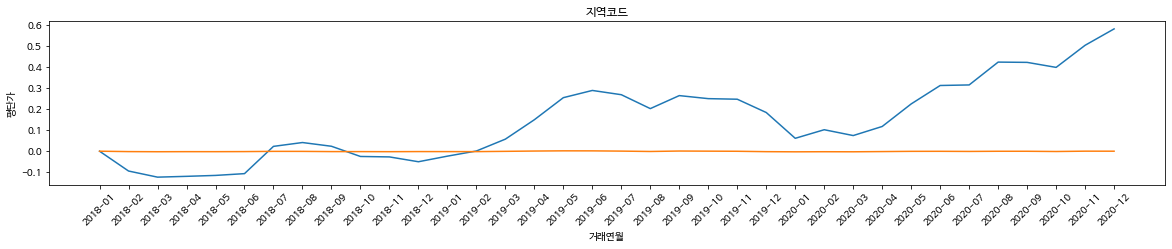

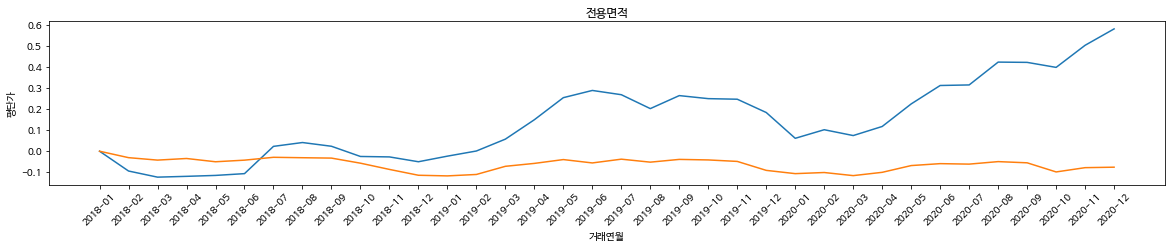

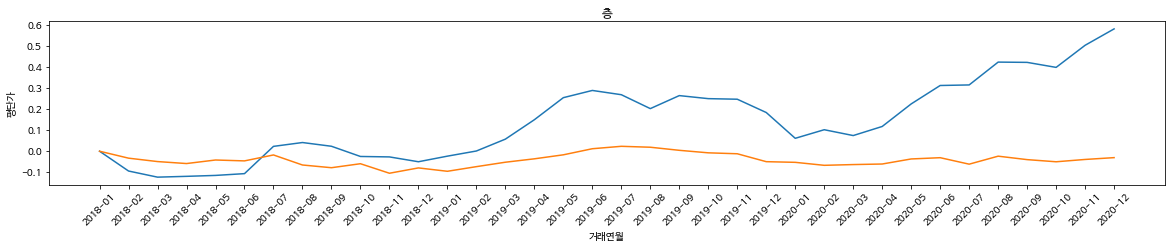

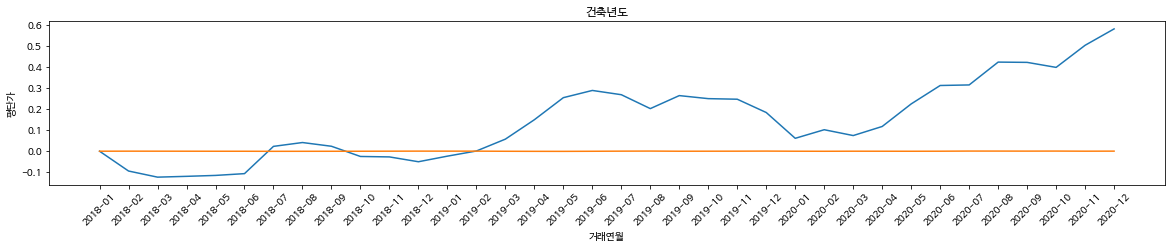

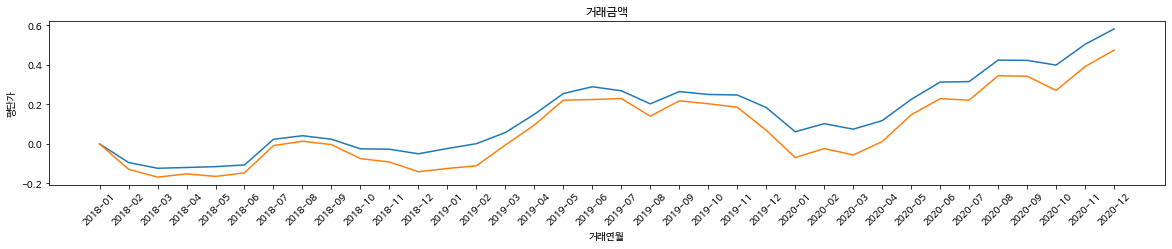

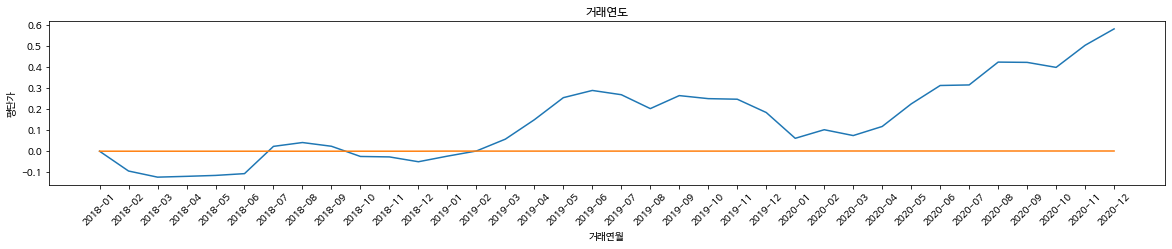

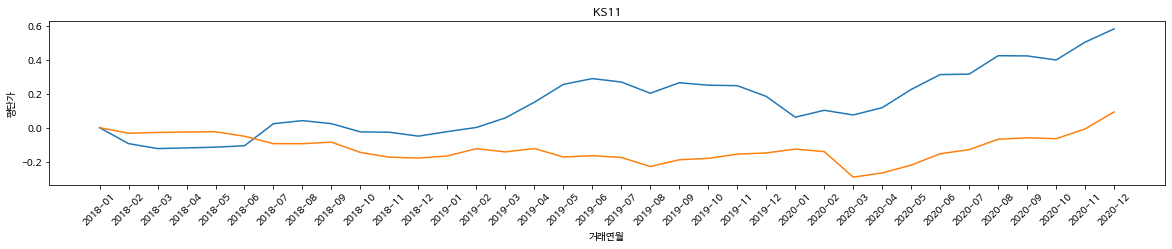

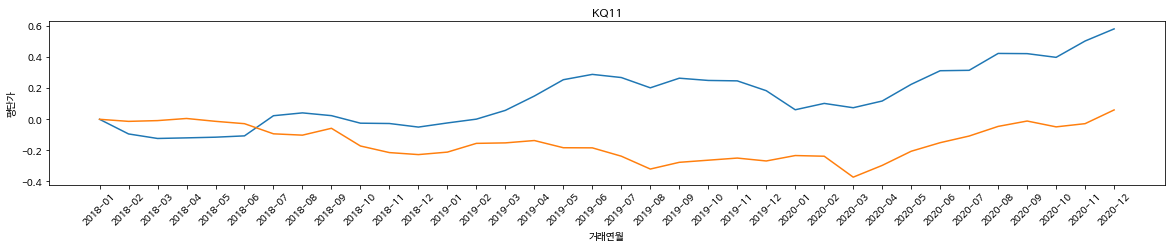

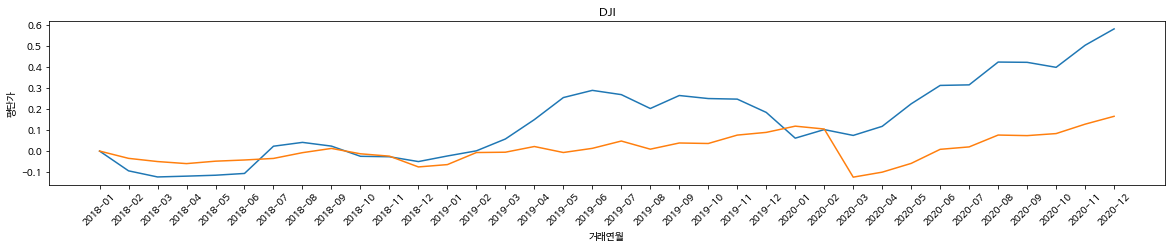

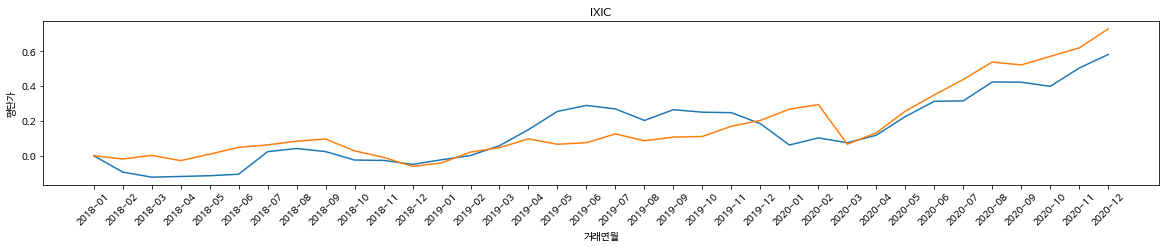

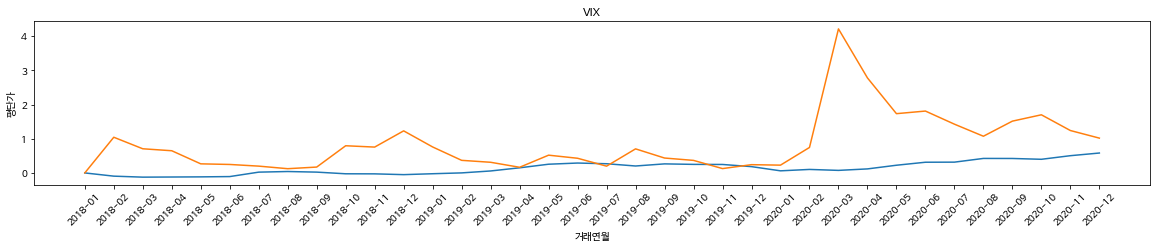

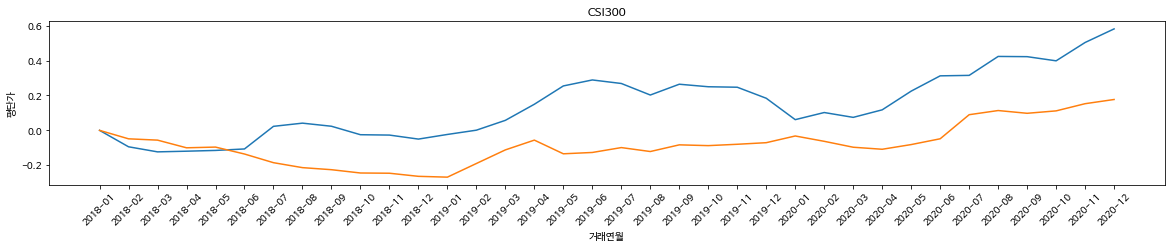

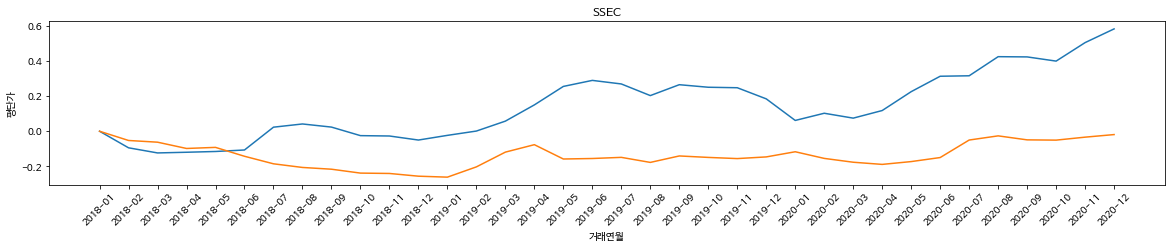

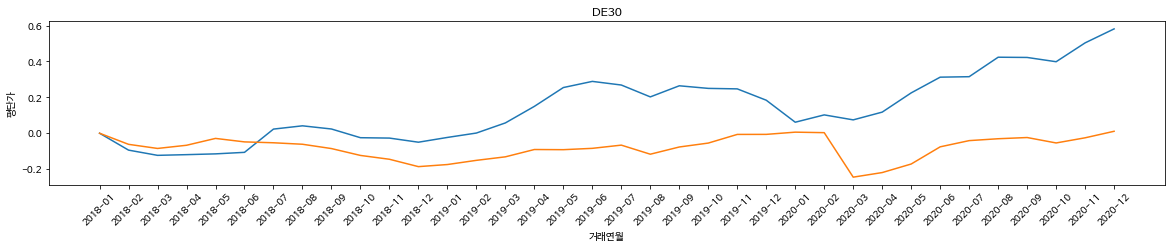

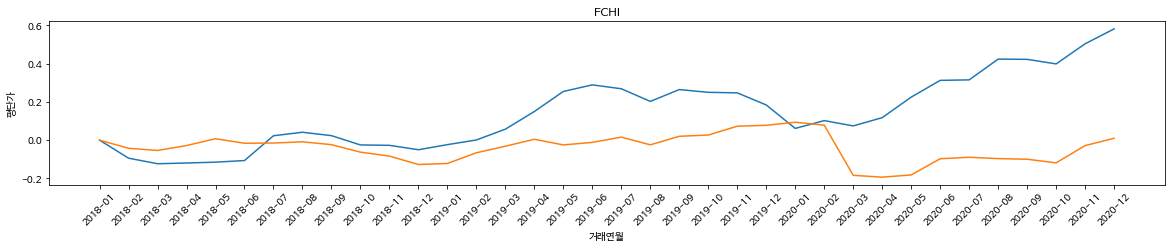

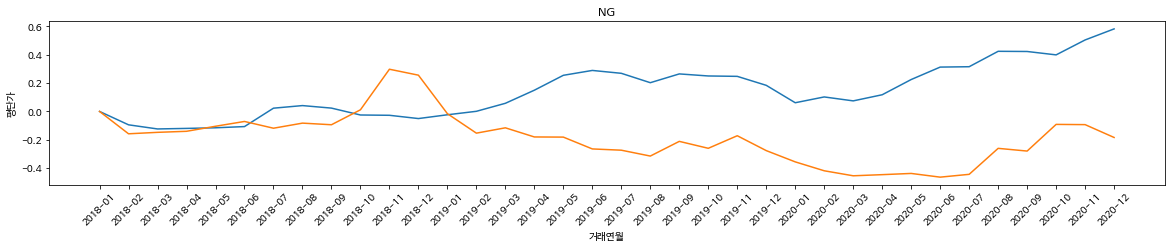

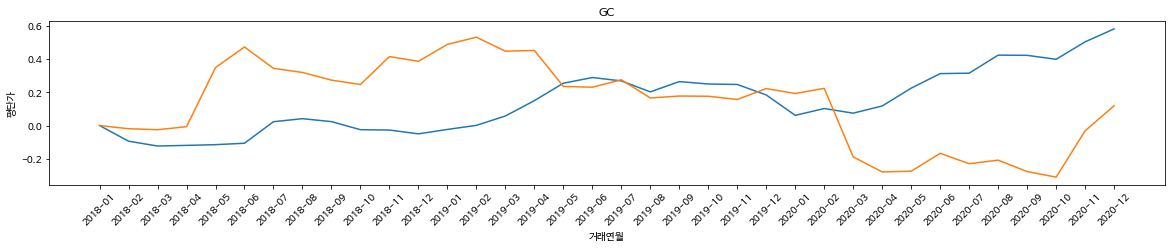

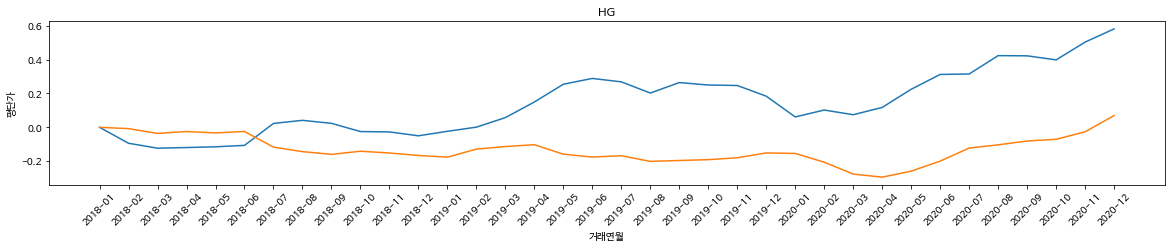

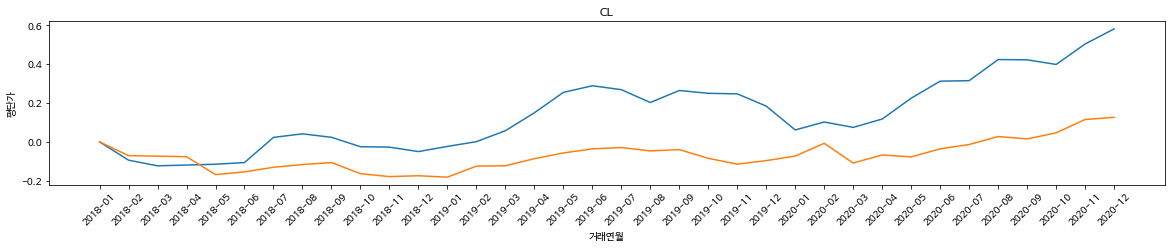

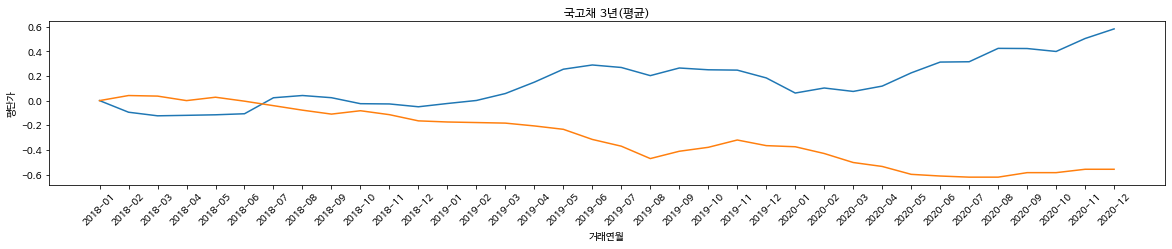

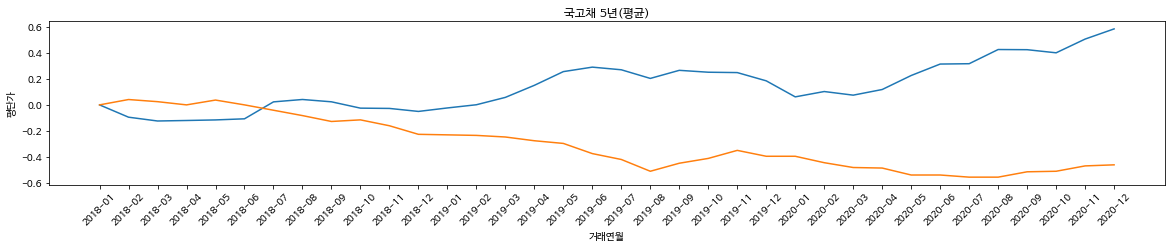

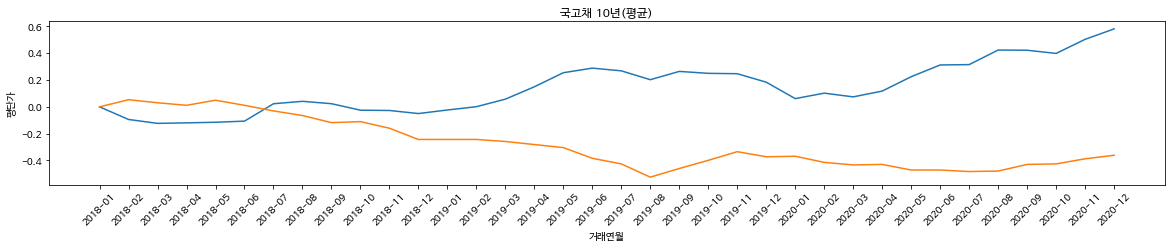

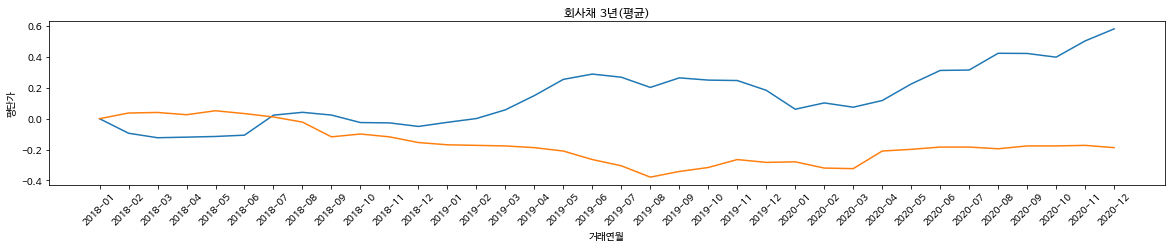

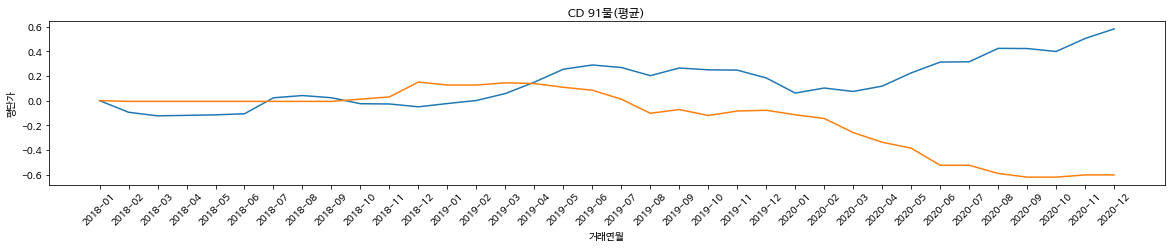

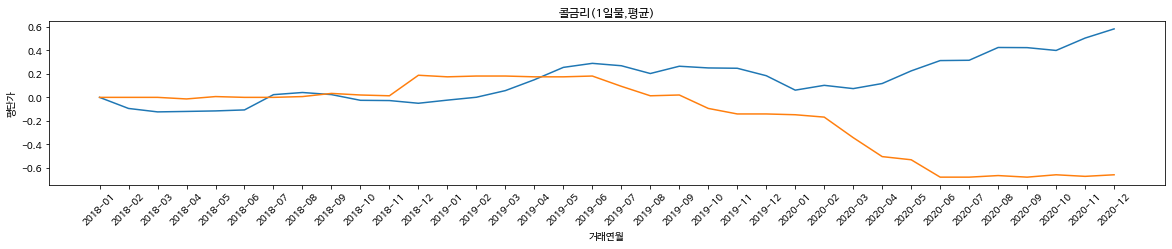

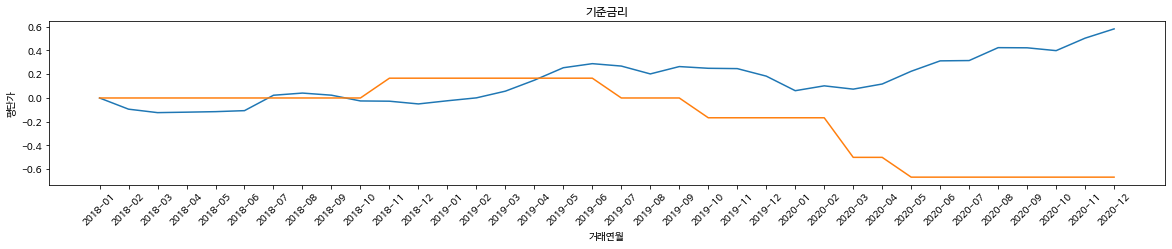

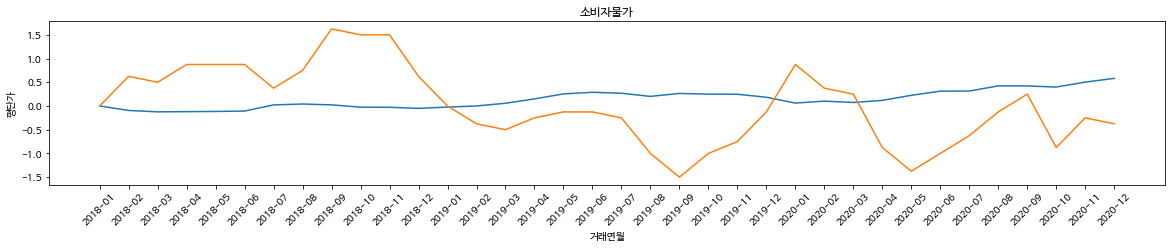

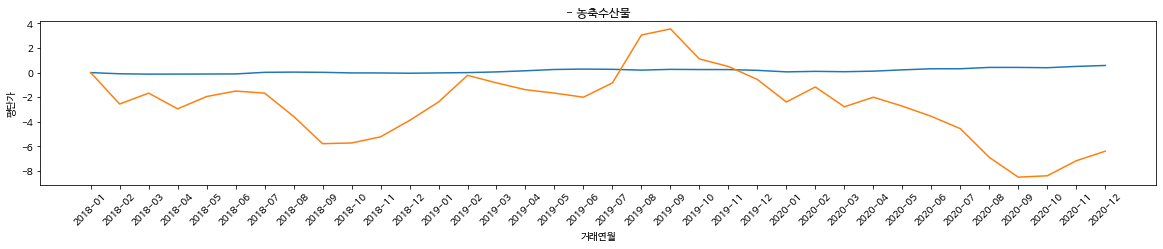

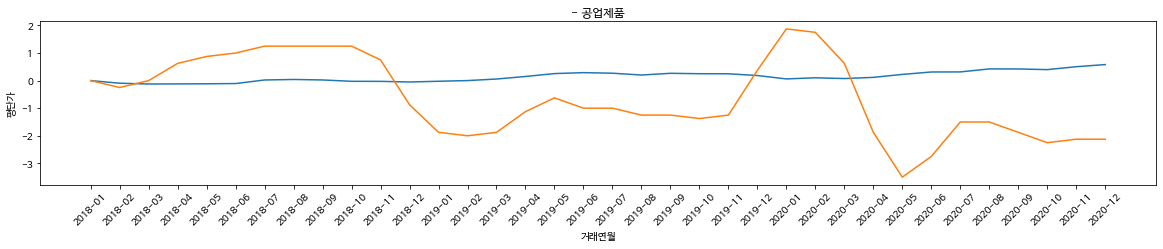

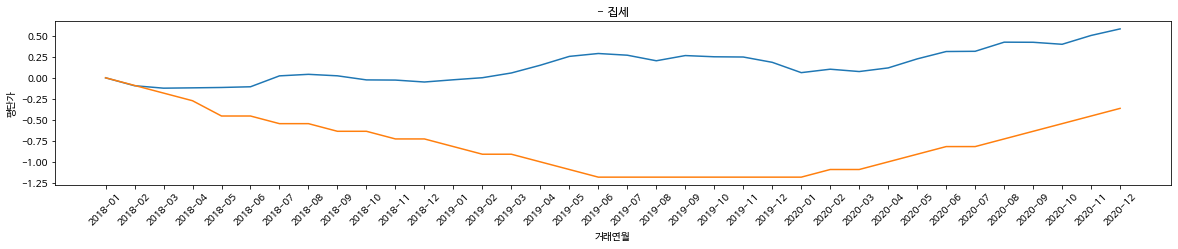

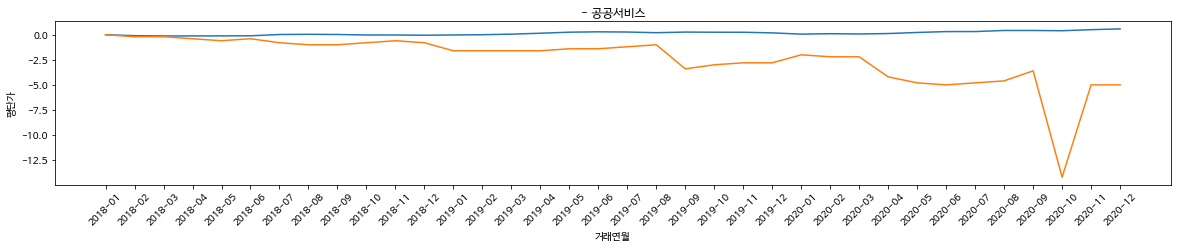

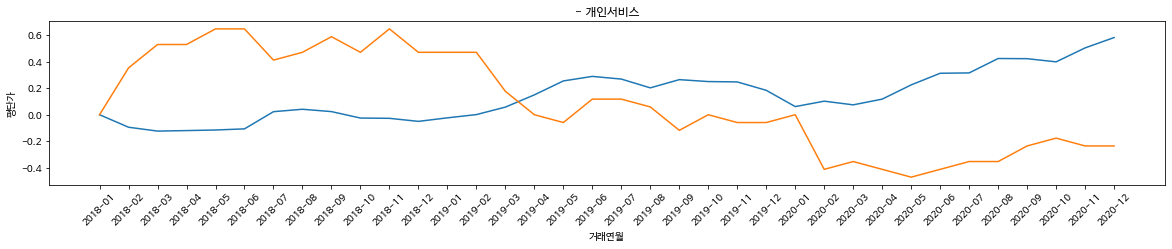

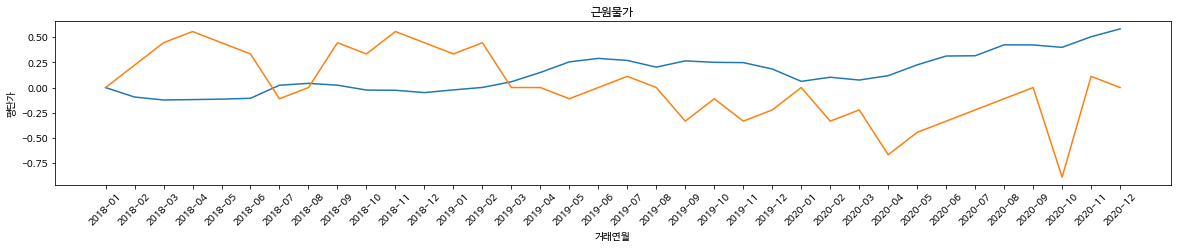

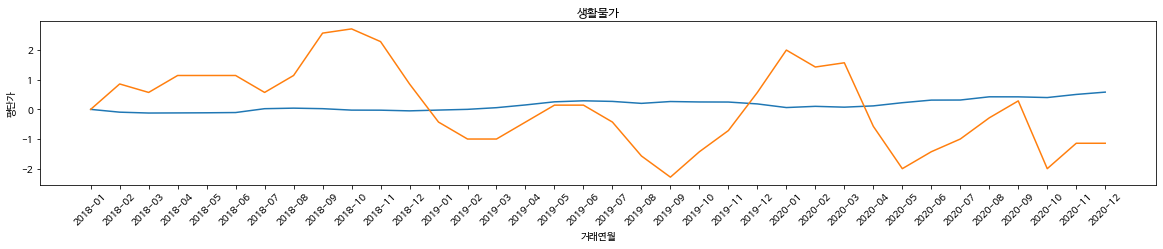

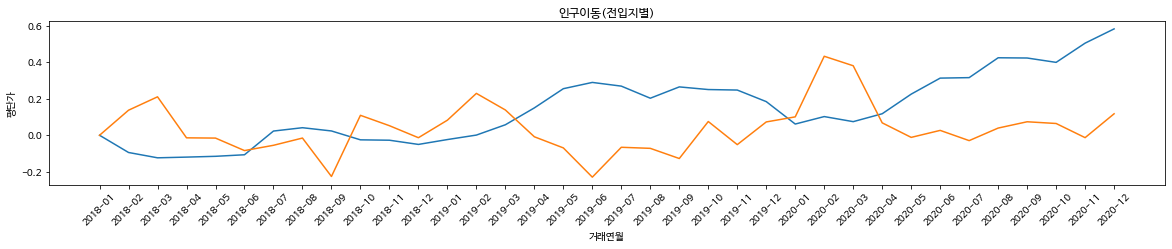

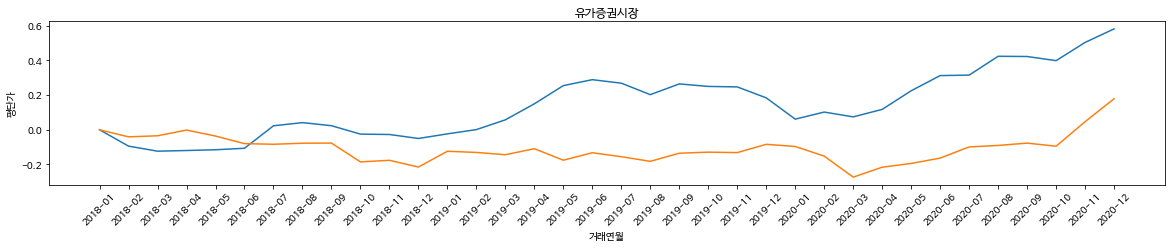

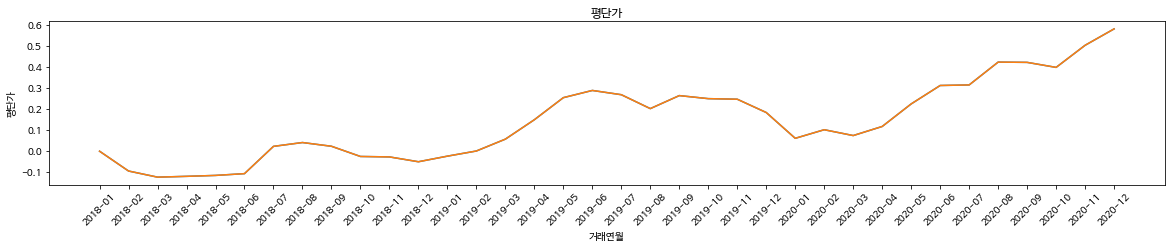

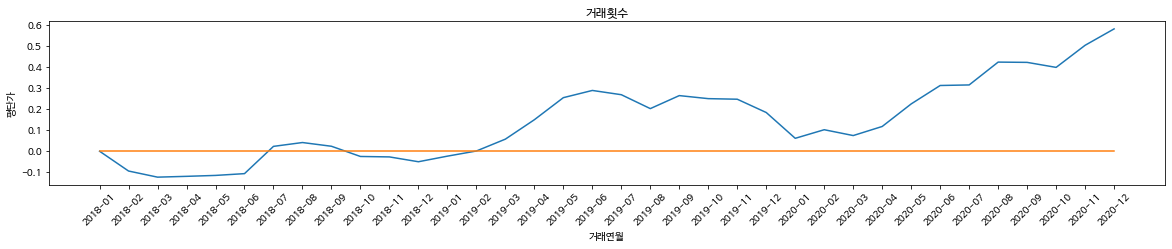

In [136]:
for col in df_norm.columns:
  plt.figure(figsize=(20,3))
  plt.xticks(rotation=45)
  plt.title(col)
  sns.lineplot(x='거래연월',y='평단가',data=df_norm)
  sns.lineplot(x='거래연월',y=col,data=df_norm)

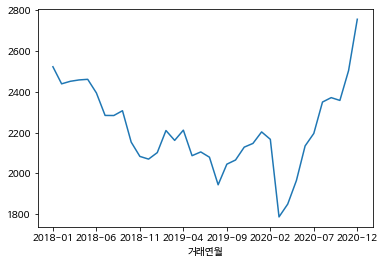

In [137]:
df_time['KS11'].plot();

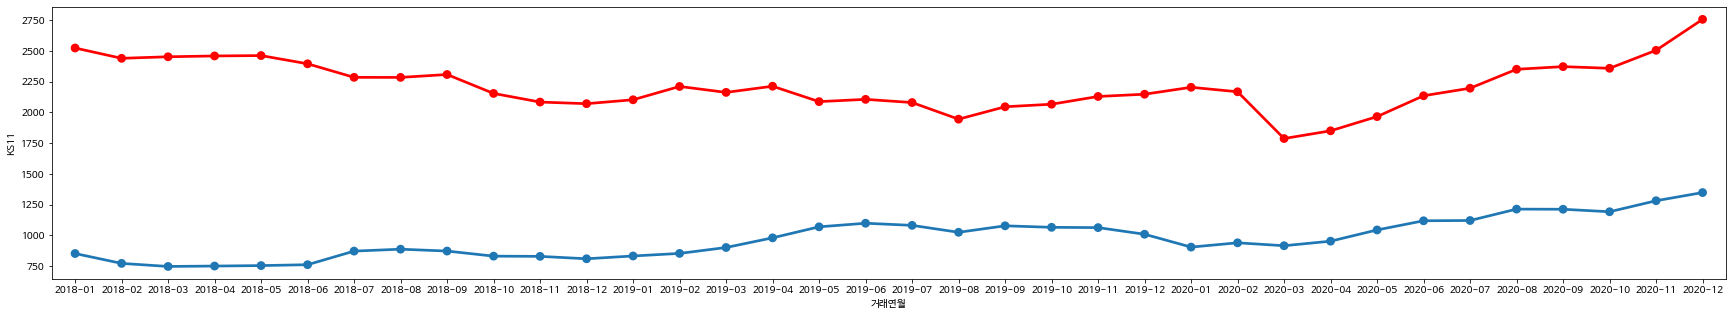

In [139]:
df_time['mean'] = (df_time['KS11']+df_time['IXIC'])/11
plt.figure(figsize=(30,5))
sns.pointplot(x="거래연월",y="평단가",data=df_time.reset_index())
sns.pointplot(x="거래연월",y="KS11",data=df_time.reset_index(),color='red');

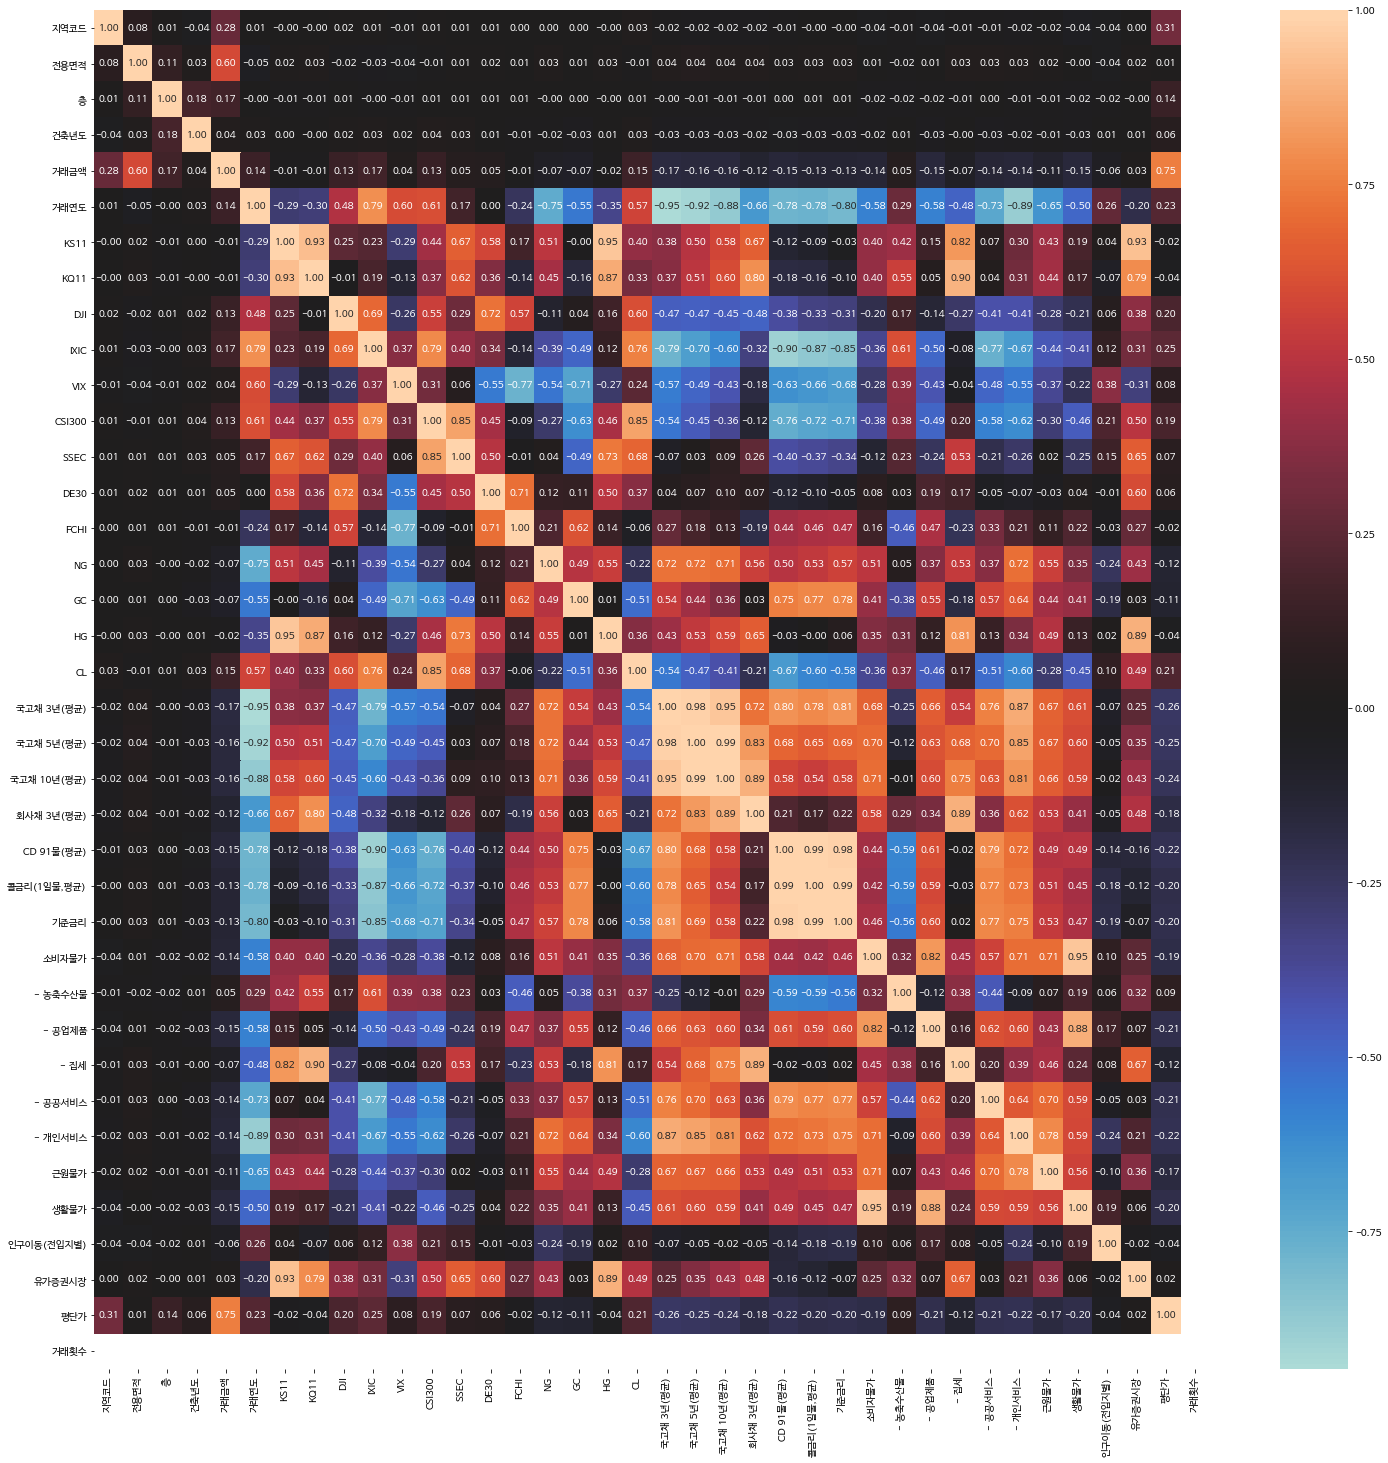

In [140]:
plt.figure(figsize=(25,25))
sns.heatmap(df.corr(),center=0,annot=True,fmt='.2f');

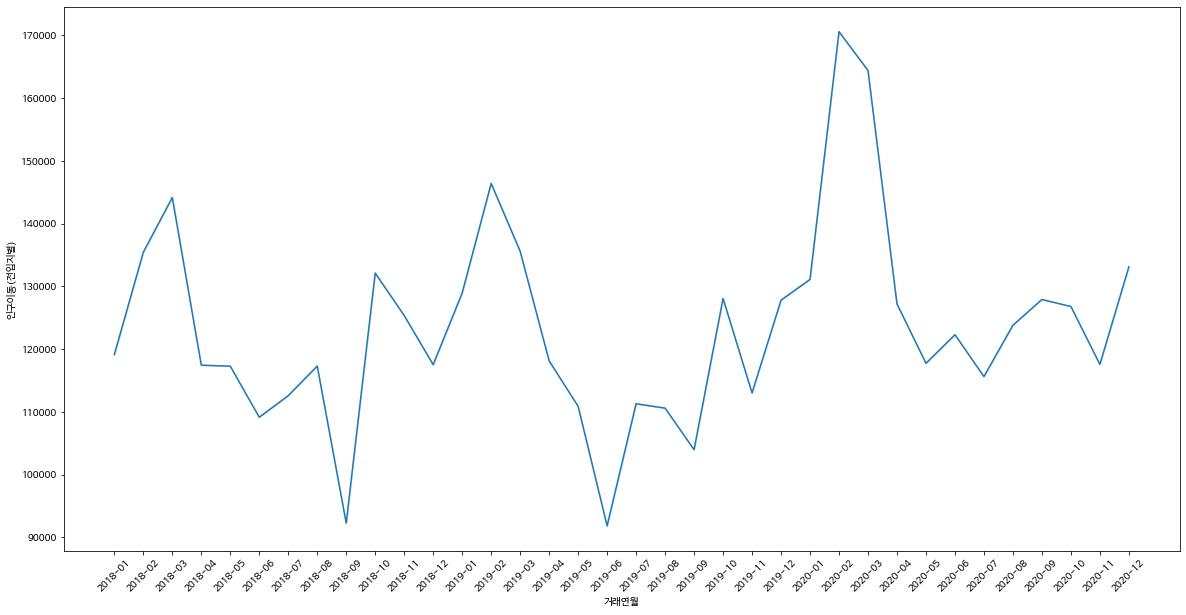

In [141]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.lineplot(data=df,x='거래연월',y='인구이동(전입지별)');

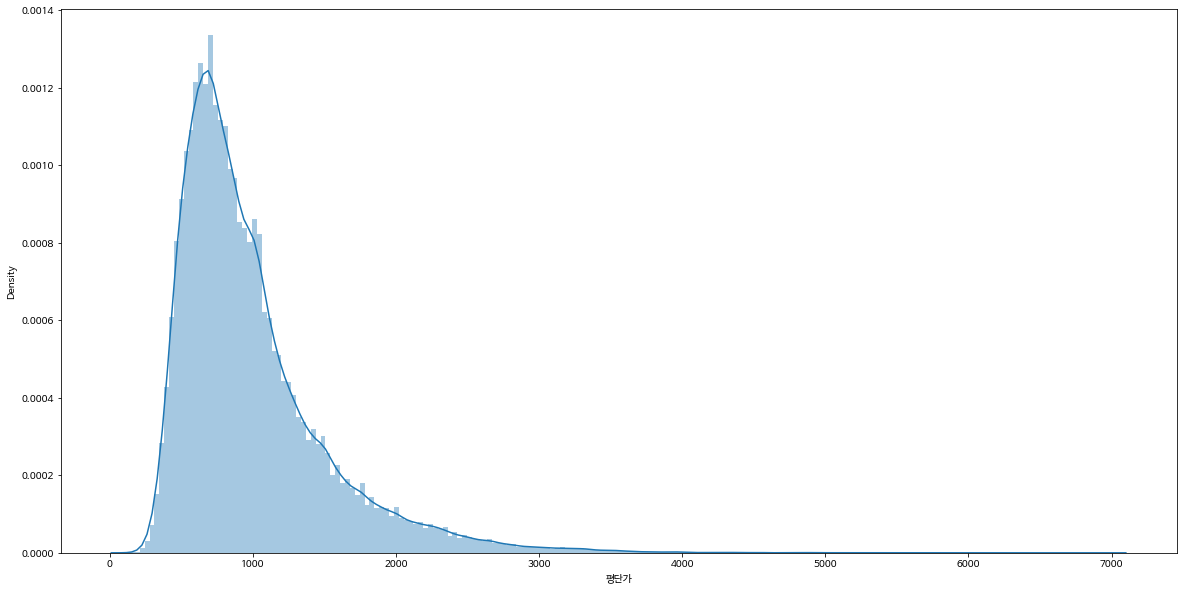

In [142]:
plt.figure(figsize=(20,10))
sns.distplot(df.평단가,bins=200)

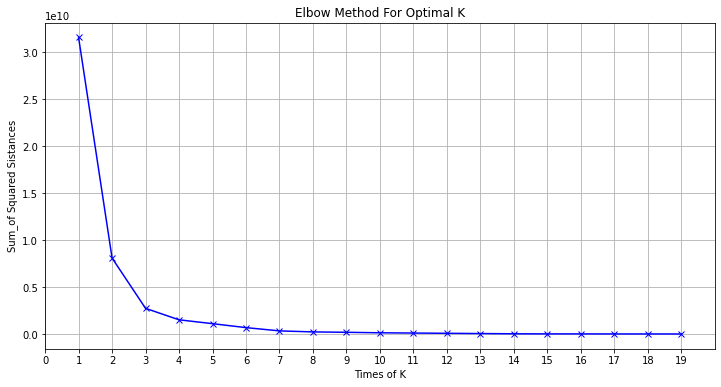

In [23]:
from sklearn.cluster import KMeans
sum_of_squared_distances = []
# df_kmeans = df_kmeans.drop('cluster',axis=1)
for n_k in range(1, 20) :
    num = KMeans(n_clusters = n_k)
    num = num.fit(rank[['평단가','거래금액']])
    sum_of_squared_distances.append(num.inertia_)

plt.figure(figsize=(12,6))

plt.xlim(0, 20)
plt.xticks(ticks=np.arange(0, 20, step=1))
plt.plot(range(1, 20), sum_of_squared_distances, 'bx-')
plt.xlabel('Times of K')
plt.ylabel('Sum_of Squared Sistances')
plt.title('Elbow Method For Optimal K')
plt.grid()
plt.show();

In [21]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(rank)

KMeans(n_clusters=5)

In [22]:
rank = rank.reset_index()

In [25]:
# rank에 rank라는 feature로 kmeans.labels_ 넣어주고 map과 zip을 활용하여 df에도 넣어준다. 
rank['rank'] = kmeans.labels_
df["rank"] = df["자치구"].map(dict(zip(rank["자치구"], rank["rank"])))

## 데이터 세팅

### 데이터 분할

In [32]:
df.head(2)

,지역코드,법정동,아파트,지번,전용면적,층,건축년도,거래금액,자치구,거래연도,거래연월,KS11,KQ11,DJI,IXIC,VIX,CSI300,SSEC,DE30,FCHI,NG,GC,HG,CL,국고채 3년(평균),국고채 5년(평균),국고채 10년(평균),회사채 3년(평균),CD 91물(평균),"콜금리(1일물,평균)",기준금리,소비자물가,- 농축수산물,- 공업제품,- 집세,- 공공서비스,- 개인서비스,근원물가,생활물가,인구이동(전입지별),유가증권시장,평단가,거래횟수,rank
0,11110,내수동,경희궁의아침2단지,71,140.78,15,2004,130000,종로구,2018,2018-01,2522.90381,875.31,25850.645238,7291.614286,11.080952,4254.521905,3462.191905,13289.680476,5492.20381,3.167429,35.101905,3.318405,75.53619,2.19,2.44,2.63,2.72,1.66,1.49,1.5,0.8,-1.8,0.8,1.1,0.5,1.7,0.9,0.7,119120,613.3,923.426623,1,3
1,11110,내수동,경희궁 파크팰리스,95,103.77,5,2003,96000,종로구,2018,2018-01,2522.90381,875.31,25850.645238,7291.614286,11.080952,4254.521905,3462.191905,13289.680476,5492.20381,3.167429,35.101905,3.318405,75.53619,2.19,2.44,2.63,2.72,1.66,1.49,1.5,0.8,-1.8,0.8,1.1,0.5,1.7,0.9,0.7,119120,613.3,925.122868,1,3


In [ ]:
target='거래금액'
train = df[(df.거래연월 != '2020-12')].copy()
test = df[(df.거래연월 == '2020-12')].copy()
print(train.shape,test.shape)
print(test.거래연월.value_counts())

X = train.drop(columns=target)
y = train[target]
X_test = test.drop(columns=target)
y_test = test[target]
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [27]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((186446, 43), (46612, 43), (186446,), (46612,))

## Base Model

In [ ]:
!pip install category_encoders

In [37]:
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder

In [180]:
from sklearn.linear_model import LinearRegression
pipe = make_pipeline(
    OrdinalEncoder(), 
    LinearRegression()
)

pipe.fit(X_train, y_train)
print('훈련 R^2: ', pipe.score(X_train, y_train))
print('검증 R^2: ', pipe.score(X_val, y_val))
print('TEST R^2: ', pipe.score(X_test, y_test))

print('\n훈련 MAE: ', mean_absolute_error(pipe.predict(X_train), y_train))
print('검증 MAE: ', mean_absolute_error(pipe.predict(X_val), y_val))
print('TEST MAE: ', mean_absolute_error(pipe.predict(X_test), y_test))

훈련 R^2:  0.9088035410333198
검증 R^2:  0.908821692925171
TEST R^2:  0.9018709836639034

훈련 MAE:  8619.429037809532
검증 MAE:  8648.369715838588
TEST MAE:  11010.727983790899


In [182]:
from xgboost.sklearn import XGBModel
from xgboost import XGBRegressor
pipe = make_pipeline(
    OrdinalEncoder(), 
    XGBRegressor(n_jobs=-1)
)

pipe.fit(X_train, y_train)
print('훈련 R^2: ', pipe.score(X_train, y_train))
print('검증 R^2: ', pipe.score(X_val, y_val))
print('TEST R^2: ', pipe.score(X_test, y_test))

print('\n훈련 MAE: ', mean_absolute_error(pipe.predict(X_train), y_train))
print('검증 MAE: ', mean_absolute_error(pipe.predict(X_val), y_val))
print('TEST MAE: ', mean_absolute_error(pipe.predict(X_test), y_test))

[08:25:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
훈련 R^2:  0.9973718264260973
검증 R^2:  0.9971619991518709
TEST R^2:  0.996802371605458

훈련 MAE:  1751.9485706007385
검증 MAE:  1789.3841473598966
TEST MAE:  2434.151284202966


In [183]:
from lightgbm import LGBMRegressor
pipe = make_pipeline(
    OrdinalEncoder(), 
    LGBMRegressor(n_jobs=-1)
)

pipe.fit(X_train, y_train)
print('훈련 R^2: ', pipe.score(X_train, y_train))
print('검증 R^2: ', pipe.score(X_val, y_val))
print('TEST R^2: ', pipe.score(X_test, y_test))

print('\n훈련 MAE: ', mean_absolute_error(pipe.predict(X_train), y_train))
print('검증 MAE: ', mean_absolute_error(pipe.predict(X_val), y_val))
print('TEST MAE: ', mean_absolute_error(pipe.predict(X_test), y_test))

훈련 R^2:  0.9990355863300701
검증 R^2:  0.998766508897224
TEST R^2:  0.9981920707039105

훈련 MAE:  859.6155873319398
검증 MAE:  892.6557948371429
TEST MAE:  1347.1228024023333


## HyperparameterTuning

### XGBoost

In [ ]:
!pip install optuna

In [30]:
import optuna

optuna를 통해 최적의 하이퍼파라미터 찾기

In [207]:
def xgb_hyper_tuning(trial,data=X,target=y):
    
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

  encoder = OrdinalEncoder()
  X_train = encoder.fit_transform(X_train)
  X_val = encoder.transform(X_val)
  
  params = {
      "n_estimators": trial.suggest_int("n_estimators",200,2000,100),
      "subsample": trial.suggest_discrete_uniform("subsample",0.6,1,0.1),
      "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree",0.6,1,0.1),
      "eta": trial.suggest_loguniform("eta",1e-3,0.1),
      "reg_alpha": trial.suggest_int("reg_alpha",1,50),
      "reg_lambda": trial.suggest_int("reg_lambda",5,100),
      "max_depth": trial.suggest_int("max_depth",5,20),
      "min_child_weight": trial.suggest_int("min_child_weight",5,20),
  }

  # warning 제거를 위해 objective='reg:squarederror' 사용
  model = XGBRegressor(**params, tree_method='gpu_hist', random_state=42, objective='reg:squarederror')
  model.fit(X_train, y_train, eval_set=[(X_val,y_val)],verbose = False, eval_metric='mae')

  y_preds = model.predict(X_val)
  loss = mean_absolute_error(y_val, y_preds)
  
  return loss

In [208]:
study = optuna.create_study(direction='minimize')
study.optimize(xgb_hyper_tuning, n_trials=100)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-19 08:46:22,986] A new study created in memory with name: no-name-f1622848-9c88-499f-ace9-2c4de5c002d6
[I 2021-08-19 08:48:39,974] Trial 0 finished with value: 1570.0433777112116 and parameters: {'n_estimators': 1100, 'subsample': 0.8, 'colsample_bytree': 0.6, 'eta': 0.026843332392453675, 'reg_alpha': 46, 'reg_lambda': 5, 'max_depth': 15, 'min_child_weight': 14}. Best is trial 0 with value: 1570.0433777112116.
[I 2021-08-19 08:48:53,514] Trial 1 finished with value: 923.1705591693965 and parameters: {'n_estimators': 1800, 'subsample': 0.8, 'colsample_bytree': 0.6, 'eta': 0.0010130634060141178, 'reg_alpha': 40, 'reg_lambda': 72, 'max_depth': 6, 'min_child_weight': 10}. Best is trial 1 with value: 923.1705591693965.
[I 2021-08-19 08:49:03,780] Trial 2 finished with value: 547.0281804967907 and parameters: {'n_estimators': 1200, 'subsample': 0.9, 'colsample_bytree': 1.0, 'eta': 0.029826527147225324, 'reg_alpha': 38, 'reg_lambda': 69, 'max_depth': 7, 'min_child_weight': 15}. Bes

Number of finished trials: 50
Best trial: score 403.2934342890679, params {'n_estimators': 2000, 'subsample': 1.0, 'colsample_bytree': 1.0, 'eta': 0.005704406371697511, 'reg_alpha': 32, 'reg_lambda': 27, 'max_depth': 19, 'min_child_weight': 14}


In [224]:
xgb_params = study.best_trial.params
xgb_params['tree_method'] = 'gpu_hist'
xgb_params['random_state'] = 42

pipe = make_pipeline(
    OrdinalEncoder(), 
    XGBRegressor(n_jobs=-1, **xgb_params,te=42, objective='reg:squarederror')
)

pipe.fit(X_train, y_train)
print('훈련 R^2: ', pipe.score(X_train, y_train))
print('검증 R^2: ', pipe.score(X_val, y_val))
print('TEST R^2: ', pipe.score(X_test, y_test))

print('\n훈련 MAE: ', mean_absolute_error(pipe.predict(X_train), y_train))
print('검증 MAE: ', mean_absolute_error(pipe.predict(X_val), y_val))
print('TEST MAE: ', mean_absolute_error(pipe.predict(X_test), y_test))

훈련 R^2:  0.9999708089581714
검증 R^2:  0.9988463193274514
TEST R^2:  0.9986361403923842

훈련 MAE:  68.59442995506659
검증 MAE:  403.2934342890679
TEST MAE:  815.5342474466685


### lightGBM

In [101]:
def lgb_hyper_tuning(trial,data=X,target=y):
    # 데이터 분리 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=42, shuffle=True)

    # 전처리 방법 선택 및 적용 
    encoder = OrdinalEncoder()
    X_train = encoder.fit_transform(X_train)
    X_val = encoder.transform(X_val)

    # 과적합을 방지하는 방향으로 하이퍼파라미터 튜닝
    params = {
    # gpu를 사용하도록 설정하는 코드 
    "tree_method": "gpu_hist", 
    
    # 몇개의 estimator를 만들지 설정하는 코드
    # 500~2000 -> 1500~2500, 그래프를 보고 변경함 
    'n_estimators': trial.suggest_int('n_estimators', 1500, 2500, 100),  
    
    # lightgbm이 사용할 수 있는 gbdt, rf, dart, goss 중 일반적인 gbdt를 사용함
    "booster": 'gbtree',  
    
    # 과적합을 방지하는 L2 정규화
    # 1~100 -> 20~100, , 그래프를 보고 변경함 
    "reg_lambda": trial.suggest_int("reg_lambda", 20, 100), 
    
    # 과적합을 방지하는 L1 정규화
    # 1~100 -> 1~50, , 그래프를 보고 변경함 
    "reg_alpha": trial.suggest_int("reg_alpha", 1, 50), 
    
    # 셈플링하는 코드 
    # 0.2~1.0 -> 0.4~1.0, 그래프를 보고 변경함 
    "subsample": trial.suggest_float("subsample", 0.4, 1.0, step=0.1), 
    
    # tree를 구성할 때 feature를 선택함
    # 최초 0.2~1.0으로 설정하였으나, 그래프를 보고 0.6~1.0으로 범위 설정 
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.1),

    # 깊이를 얼마나 깊이 갈 것인지를 설정하는 코드 
    # 3~8  -> 3~20으로 변경 -> 사유 : 그래프가 대부분 8의 값을 가짐 
    "max_depth": trial.suggest_int("max_depth", 3, 20), 
    
    # 관측치에 대한 가중치 합의 최소를 말하지만 GBM에서는 관측치 수에 대한 최소를 의미함 
    # 2~10 -> 2~15로 변경, 그래프를 보고 변경함 
    "min_child_weight": trial.suggest_int("min_child_weight", 2, 15), 

    # 감마 값을 설정하는 코드 
    # 최초 0~20을 설정하였으나, 그래프를 보고 15로 줄임 
    "gamma": trial.suggest_float("gamma", 0, 15), 



    # ----최초 성능을 뽑은 후 과적합을 제재하기 위한 코드 추가 ----


    # 학습하는 속도 
    "learning_rate":0.01,

    # 과적합을 방지하는 정규화 방식으로 주로 L1, L2와 함께 사용됨 
    "min_gain_to_split" : trial.suggest_int("min_gain_to_split", 1, 100), 

    # 데이터의 일부만을 사용하는 bagging의 비율
    "bagging_fraction" :trial.suggest_float("bagging_fraction", 0.0, 1.0),
    
    # bagging을 가능하도록 하는 코드 0보다 커야함 
    "bagging_freq": trial.suggest_int("bagging_freq", 1, 15),

    # feature를 고르게 하는 코드 
    "feature_fraction" : trial.suggest_float("feature_fraction", 0.0, 1.0),

    # 극도로 랜덤하흔 트리를 만드는 코드 
    "extra_trees" : trial.suggest_categorical('extra_trees', [True, False]),
}
    
    eval_set = [(X_val, y_val)]
    fit_params = dict(eval_set=eval_set, eval_metric='mae', 
                      early_stopping_rounds=100, verbose=False)
    
    # 모델 선정 및 params 입력 
    model = LGBMRegressor(**params,random_state=42)
    
    # 모델 훈련 
    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],verbose = False)

    # 모델 예측 
    y_preds = model.predict(X_val)

    # rmse 계산 
    loss = mean_absolute_error(y_val, y_preds)
    
    return loss

In [332]:
study = optuna.create_study(direction='minimize')
study.optimize(lgb_hyper_tuning, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-19 16:18:25,954] A new study created in memory with name: no-name-292276ff-e3cb-46c1-91af-29abecf2fb31
[I 2021-08-19 16:20:34,135] Trial 0 finished with value: 981.3273580110147 and parameters: {'n_estimators': 2500, 'reg_lambda': 49, 'reg_alpha': 12, 'subsample': 0.5, 'colsample_bytree': 0.8, 'max_depth': 19, 'min_child_weight': 10, 'gamma': 3.8612673952368235, 'learning_rate': 0.0050812749021837455, 'min_gain_to_split': 66, 'bagging_fraction': 0.9466646372080473, 'bagging_freq': 8, 'feature_fraction': 0.8693879001858965, 'extra_trees': False}. Best is trial 0 with value: 981.3273580110147.
[I 2021-08-19 16:21:38,328] Trial 1 finished with value: 3304.259476684322 and parameters: {'n_estimators': 2000, 'reg_lambda': 68, 'reg_alpha': 22, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.6, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 9.87126679675052, 'learning_rate': 0.004746243986036022, 'min_gain_to_split': 42, 'bagging_fraction': 0.6440066357713679, 'bagging_fr

Number of finished trials: 50
Best trial: score 684.6662271329178, params {'n_estimators': 2200, 'reg_lambda': 28, 'reg_alpha': 21, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 14.109818272977083, 'learning_rate': 0.009417857227437001, 'min_gain_to_split': 51, 'bagging_fraction': 0.7903440423648653, 'bagging_freq': 9, 'feature_fraction': 0.9990910071589436, 'extra_trees': False}


In [333]:
lgb_params = study.best_trial.params
lgb_params['tree_method'] = 'gpu_hist'
lgb_params['random_state'] = 42

pipe = make_pipeline(
    OrdinalEncoder(), 
    LGBMRegressor(n_jobs=-1, **lgb_params)
)

pipe.fit(X_train, y_train)
print('훈련 R^2: ', pipe.score(X_train, y_train))
print('검증 R^2: ', pipe.score(X_val, y_val))
print('TEST R^2: ', pipe.score(X_test, y_test))

print('\n훈련 MAE: ', mean_absolute_error(pipe.predict(X_train), y_train))
print('검증 MAE: ', mean_absolute_error(pipe.predict(X_val), y_val))
print('TEST MAE: ', mean_absolute_error(pipe.predict(X_test), y_test))

훈련 R^2:  0.9993137358345543
검증 R^2:  0.9990266696299275
TEST R^2:  0.9985135714333658

훈련 MAE:  661.0760166587567
검증 MAE:  702.3820323697311
TEST MAE:  1145.3759647641239


In [41]:
def lgb_hyper_tuning1(trial,data=X,target=y):
    # 데이터 분리 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=42, shuffle=True)

    # 전처리 방법 선택 및 적용 
    encoder = OrdinalEncoder()
    X_train = encoder.fit_transform(X_train)
    X_val = encoder.transform(X_val)

    # 과적합을 방지하는 방향으로 하이퍼파라미터 튜닝
    params = {
    # gpu를 사용하도록 설정하는 코드 
    "tree_method": "gpu_hist", 
    
    # 몇개의 estimator를 만들지 설정하는 코드
    # 500~2000 -> 1500~2500, 그래프를 보고 변경함 
    'n_estimators': trial.suggest_int('n_estimators', 1500, 2500, 100),  
    
    # lightgbm이 사용할 수 있는 gbdt, rf, dart, goss 중 일반적인 gbdt를 사용함
    "booster": 'gbtree',  
    
    # 과적합을 방지하는 L2 정규화
    # 1~100 -> 20~100, , 그래프를 보고 변경함 
    "reg_lambda": trial.suggest_int("reg_lambda", 20, 100), 
    
    # 과적합을 방지하는 L1 정규화
    # 1~100 -> 1~50, , 그래프를 보고 변경함 
    "reg_alpha": trial.suggest_int("reg_alpha", 1, 50), 
    
    # 셈플링하는 코드 
    # 0.2~1.0 -> 0.4~1.0, 그래프를 보고 변경함 
    "subsample": trial.suggest_float("subsample", 0.4, 1.0, step=0.1), 
    
    # tree를 구성할 때 feature를 선택함
    # 최초 0.2~1.0으로 설정하였으나, 그래프를 보고 0.6~1.0으로 범위 설정 
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.1),

    # 깊이를 얼마나 깊이 갈 것인지를 설정하는 코드 
    # 3~8  -> 3~20으로 변경 -> 사유 : 그래프가 대부분 8의 값을 가짐 
    "max_depth": trial.suggest_int("max_depth", 3, 20), 
    
    # 관측치에 대한 가중치 합의 최소를 말하지만 GBM에서는 관측치 수에 대한 최소를 의미함 
    # 2~10 -> 2~15로 변경, 그래프를 보고 변경함 
    "min_child_weight": trial.suggest_int("min_child_weight", 2, 15), 

    # 감마 값을 설정하는 코드 
    # 최초 0~20을 설정하였으나, 그래프를 보고 15로 줄임 
    "gamma": trial.suggest_float("gamma", 0, 15), 



    # ----최초 성능을 뽑은 후 과적합을 제재하기 위한 코드 추가 ----


    # 학습하는 속도 
    "learning_rate": 0.01}
    
    eval_set = [(X_val, y_val)]
    fit_params = dict(eval_set=eval_set, eval_metric='mae', 
                      early_stopping_rounds=100, verbose=False)
    
    # 모델 선정 및 params 입력 
    model = LGBMRegressor(**params,random_state=42)
    
    # 모델 훈련 
    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],verbose = False)

    # 모델 예측 
    y_preds = model.predict(X_val)

    # rmse 계산 
    loss = mean_absolute_error(y_val, y_preds)
    
    return loss

In [335]:

def lgb_hyper_tuning2(trial,data=X,target=y):
    # 데이터 분리 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=42, shuffle=True)

    # 전처리 방법 선택 및 적용 
    encoder = OrdinalEncoder()
    X_train = encoder.fit_transform(X_train)
    X_val = encoder.transform(X_val)

    # 과적합을 방지하는 방향으로 하이퍼파라미터 튜닝
    params = {
    # gpu를 사용하도록 설정하는 코드 
    "tree_method": "gpu_hist", 
    
    # 몇개의 estimator를 만들지 설정하는 코드
    # 500~2000 -> 1500~2500, 그래프를 보고 변경함 
    'n_estimators': trial.suggest_int('n_estimators', 1500, 2500, 100),  
    
    # lightgbm이 사용할 수 있는 gbdt, rf, dart, goss 중 일반적인 gbdt를 사용함
    "booster": 'gbtree',  
    
    # 과적합을 방지하는 L2 정규화
    # 1~100 -> 20~100, , 그래프를 보고 변경함 
    "reg_lambda": trial.suggest_int("reg_lambda", 20, 100), 
    
    # 과적합을 방지하는 L1 정규화
    # 1~100 -> 1~50, , 그래프를 보고 변경함 
    "reg_alpha": trial.suggest_int("reg_alpha", 1, 50), 
    
    # 셈플링하는 코드 
    # 0.2~1.0 -> 0.4~1.0, 그래프를 보고 변경함 
    "subsample": trial.suggest_float("subsample", 0.4, 1.0, step=0.1), 
    
    # tree를 구성할 때 feature를 선택함
    # 최초 0.2~1.0으로 설정하였으나, 그래프를 보고 0.6~1.0으로 범위 설정 
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.1),

    # 깊이를 얼마나 깊이 갈 것인지를 설정하는 코드 
    # 3~8  -> 3~20으로 변경 -> 사유 : 그래프가 대부분 8의 값을 가짐 
    "max_depth": trial.suggest_int("max_depth", 3, 20), 
    
    # 관측치에 대한 가중치 합의 최소를 말하지만 GBM에서는 관측치 수에 대한 최소를 의미함 
    # 2~10 -> 2~15로 변경, 그래프를 보고 변경함 
    "min_child_weight": trial.suggest_int("min_child_weight", 2, 15), 

    # 감마 값을 설정하는 코드 
    # 최초 0~20을 설정하였으나, 그래프를 보고 15로 줄임 
    "gamma": trial.suggest_float("gamma", 0, 15), 



    # ----최초 성능을 뽑은 후 과적합을 제재하기 위한 코드 추가 ----


    # 학습하는 속도 
    "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),

    # 과적합을 방지하는 정규화 방식으로 주로 L1, L2와 함께 사용됨 
    "min_gain_to_split" : trial.suggest_int("min_gain_to_split", 1, 100), 
}
    
    eval_set = [(X_val, y_val)]
    fit_params = dict(eval_set=eval_set, eval_metric='mae', 
                      early_stopping_rounds=100, verbose=False)
    
    # 모델 선정 및 params 입력 
    model = LGBMRegressor(**params,random_state=42)
    
    # 모델 훈련 
    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],verbose = False)

    # 모델 예측 
    y_preds = model.predict(X_val)

    # rmse 계산 
    loss = mean_absolute_error(y_val, y_preds)
    
    return loss

In [336]:

def lgb_hyper_tuning3(trial,data=X,target=y):
    # 데이터 분리 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=42, shuffle=True)

    # 전처리 방법 선택 및 적용 
    encoder = OrdinalEncoder()
    X_train = encoder.fit_transform(X_train)
    X_val = encoder.transform(X_val)

    # 과적합을 방지하는 방향으로 하이퍼파라미터 튜닝
    params = {
    # gpu를 사용하도록 설정하는 코드 
    "tree_method": "gpu_hist", 
    
    # 몇개의 estimator를 만들지 설정하는 코드
    # 500~2000 -> 1500~2500, 그래프를 보고 변경함 
    'n_estimators': trial.suggest_int('n_estimators', 1500, 2500, 100),  
    
    # lightgbm이 사용할 수 있는 gbdt, rf, dart, goss 중 일반적인 gbdt를 사용함
    "booster": 'gbtree',  
    
    # 과적합을 방지하는 L2 정규화
    # 1~100 -> 20~100, , 그래프를 보고 변경함 
    "reg_lambda": trial.suggest_int("reg_lambda", 20, 100), 
    
    # 과적합을 방지하는 L1 정규화
    # 1~100 -> 1~50, , 그래프를 보고 변경함 
    "reg_alpha": trial.suggest_int("reg_alpha", 1, 50), 
    
    # 셈플링하는 코드 
    # 0.2~1.0 -> 0.4~1.0, 그래프를 보고 변경함 
    "subsample": trial.suggest_float("subsample", 0.4, 1.0, step=0.1), 
    
    # tree를 구성할 때 feature를 선택함
    # 최초 0.2~1.0으로 설정하였으나, 그래프를 보고 0.6~1.0으로 범위 설정 
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.1),

    # 깊이를 얼마나 깊이 갈 것인지를 설정하는 코드 
    # 3~8  -> 3~20으로 변경 -> 사유 : 그래프가 대부분 8의 값을 가짐 
    "max_depth": trial.suggest_int("max_depth", 3, 20), 
    
    # 관측치에 대한 가중치 합의 최소를 말하지만 GBM에서는 관측치 수에 대한 최소를 의미함 
    # 2~10 -> 2~15로 변경, 그래프를 보고 변경함 
    "min_child_weight": trial.suggest_int("min_child_weight", 2, 15), 

    # 감마 값을 설정하는 코드 
    # 최초 0~20을 설정하였으나, 그래프를 보고 15로 줄임 
    "gamma": trial.suggest_float("gamma", 0, 15), 



    # ----최초 성능을 뽑은 후 과적합을 제재하기 위한 코드 추가 ----


    # 학습하는 속도 
    "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),

    # 과적합을 방지하는 정규화 방식으로 주로 L1, L2와 함께 사용됨 
    "min_gain_to_split" : trial.suggest_int("min_gain_to_split", 1, 100), 

    # 데이터의 일부만을 사용하는 bagging의 비율
    "bagging_fraction" :trial.suggest_float("bagging_fraction", 0.0, 1.0),
   
}
    
    eval_set = [(X_val, y_val)]
    fit_params = dict(eval_set=eval_set, eval_metric='mae', 
                      early_stopping_rounds=100, verbose=False)
    
    # 모델 선정 및 params 입력 
    model = LGBMRegressor(**params,random_state=42)
    
    # 모델 훈련 
    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],verbose = False)

    # 모델 예측 
    y_preds = model.predict(X_val)

    # rmse 계산 
    loss = mean_absolute_error(y_val, y_preds)
    
    return loss

In [337]:

def lgb_hyper_tuning4(trial,data=X,target=y):
    # 데이터 분리 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=42, shuffle=True)

    # 전처리 방법 선택 및 적용 
    encoder = OrdinalEncoder()
    X_train = encoder.fit_transform(X_train)
    X_val = encoder.transform(X_val)

    # 과적합을 방지하는 방향으로 하이퍼파라미터 튜닝
    params = {
    # gpu를 사용하도록 설정하는 코드 
    "tree_method": "gpu_hist", 
    
    # 몇개의 estimator를 만들지 설정하는 코드
    # 500~2000 -> 1500~2500, 그래프를 보고 변경함 
    'n_estimators': trial.suggest_int('n_estimators', 1500, 2500, 100),  
    
    # lightgbm이 사용할 수 있는 gbdt, rf, dart, goss 중 일반적인 gbdt를 사용함
    "booster": 'gbtree',  
    
    # 과적합을 방지하는 L2 정규화
    # 1~100 -> 20~100, , 그래프를 보고 변경함 
    "reg_lambda": trial.suggest_int("reg_lambda", 20, 100), 
    
    # 과적합을 방지하는 L1 정규화
    # 1~100 -> 1~50, , 그래프를 보고 변경함 
    "reg_alpha": trial.suggest_int("reg_alpha", 1, 50), 
    
    # 셈플링하는 코드 
    # 0.2~1.0 -> 0.4~1.0, 그래프를 보고 변경함 
    "subsample": trial.suggest_float("subsample", 0.4, 1.0, step=0.1), 
    
    # tree를 구성할 때 feature를 선택함
    # 최초 0.2~1.0으로 설정하였으나, 그래프를 보고 0.6~1.0으로 범위 설정 
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.1),

    # 깊이를 얼마나 깊이 갈 것인지를 설정하는 코드 
    # 3~8  -> 3~20으로 변경 -> 사유 : 그래프가 대부분 8의 값을 가짐 
    "max_depth": trial.suggest_int("max_depth", 3, 20), 
    
    # 관측치에 대한 가중치 합의 최소를 말하지만 GBM에서는 관측치 수에 대한 최소를 의미함 
    # 2~10 -> 2~15로 변경, 그래프를 보고 변경함 
    "min_child_weight": trial.suggest_int("min_child_weight", 2, 15), 

    # 감마 값을 설정하는 코드 
    # 최초 0~20을 설정하였으나, 그래프를 보고 15로 줄임 
    "gamma": trial.suggest_float("gamma", 0, 15), 



    # ----최초 성능을 뽑은 후 과적합을 제재하기 위한 코드 추가 ----


    # 학습하는 속도 
    "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),

    # 과적합을 방지하는 정규화 방식으로 주로 L1, L2와 함께 사용됨 
    "min_gain_to_split" : trial.suggest_int("min_gain_to_split", 1, 100), 

    # 데이터의 일부만을 사용하는 bagging의 비율
    "bagging_fraction" :trial.suggest_float("bagging_fraction", 0.0, 1.0),
    
    # bagging을 가능하도록 하는 코드 0보다 커야함 
    "bagging_freq": trial.suggest_int("bagging_freq", 1, 15),

}
    
    eval_set = [(X_val, y_val)]
    fit_params = dict(eval_set=eval_set, eval_metric='mae', 
                      early_stopping_rounds=100, verbose=False)
    
    # 모델 선정 및 params 입력 
    model = LGBMRegressor(**params,random_state=42)
    
    # 모델 훈련 
    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],verbose = False)

    # 모델 예측 
    y_preds = model.predict(X_val)

    # rmse 계산 
    loss = mean_absolute_error(y_val, y_preds)
    
    return loss

In [42]:
def lgb_hyper_tuning5(trial,data=X,target=y):
    # 데이터 분리 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=42, shuffle=True)

    # 전처리 방법 선택 및 적용 
    encoder = OrdinalEncoder()
    X_train = encoder.fit_transform(X_train)
    X_val = encoder.transform(X_val)

    # 과적합을 방지하는 방향으로 하이퍼파라미터 튜닝
    params = {
    # gpu를 사용하도록 설정하는 코드 
    "tree_method": "gpu_hist", 
    
    # 몇개의 estimator를 만들지 설정하는 코드
    # 500~2000 -> 1500~2500, 그래프를 보고 변경함 
    'n_estimators': trial.suggest_int('n_estimators', 1500, 2500, 100),  
    
    # lightgbm이 사용할 수 있는 gbdt, rf, dart, goss 중 일반적인 gbdt를 사용함
    "booster": 'gbtree',  
    
    # 과적합을 방지하는 L2 정규화
    # 1~100 -> 20~100, , 그래프를 보고 변경함 
    "reg_lambda": trial.suggest_int("reg_lambda", 20, 100), 
    
    # 과적합을 방지하는 L1 정규화
    # 1~100 -> 1~50, , 그래프를 보고 변경함 
    "reg_alpha": trial.suggest_int("reg_alpha", 1, 50), 
    
    # 셈플링하는 코드 
    # 0.2~1.0 -> 0.4~1.0, 그래프를 보고 변경함 
    "subsample": trial.suggest_float("subsample", 0.4, 1.0, step=0.1), 
    
    # tree를 구성할 때 feature를 선택함
    # 최초 0.2~1.0으로 설정하였으나, 그래프를 보고 0.6~1.0으로 범위 설정 
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.1),

    # 깊이를 얼마나 깊이 갈 것인지를 설정하는 코드 
    # 3~8  -> 3~20으로 변경 -> 사유 : 그래프가 대부분 8의 값을 가짐 
    "max_depth": trial.suggest_int("max_depth", 3, 20), 
    
    # 관측치에 대한 가중치 합의 최소를 말하지만 GBM에서는 관측치 수에 대한 최소를 의미함 
    # 2~10 -> 2~15로 변경, 그래프를 보고 변경함 
    "min_child_weight": trial.suggest_int("min_child_weight", 2, 15), 

    # 감마 값을 설정하는 코드 
    # 최초 0~20을 설정하였으나, 그래프를 보고 15로 줄임 
    "gamma": trial.suggest_float("gamma", 0, 15), 



    # ----최초 성능을 뽑은 후 과적합을 제재하기 위한 코드 추가 ----


    # 학습하는 속도 
    "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),

    # 과적합을 방지하는 정규화 방식으로 주로 L1, L2와 함께 사용됨 
    "min_gain_to_split" : trial.suggest_int("min_gain_to_split", 1, 100), 

    # 데이터의 일부만을 사용하는 bagging의 비율
    "bagging_fraction" :trial.suggest_float("bagging_fraction", 0.0, 1.0),
    
    # bagging을 가능하도록 하는 코드 0보다 커야함 
    "bagging_freq": trial.suggest_int("bagging_freq", 1, 15),

    # feature를 고르게 하는 코드 
    "feature_fraction" : trial.suggest_float("feature_fraction", 0.0, 1.0),

}
    
    eval_set = [(X_val, y_val)]
    fit_params = dict(eval_set=eval_set, eval_metric='mae', 
                      early_stopping_rounds=100, verbose=False)
    
    # 모델 선정 및 params 입력 
    model = LGBMRegressor(**params,random_state=42)
    
    # 모델 훈련 
    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],verbose = False)

    # 모델 예측 
    y_preds = model.predict(X_val)

    # rmse 계산 
    loss = mean_absolute_error(y_val, y_preds)
    
    return loss

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(lgb_hyper_tuning1, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

In [341]:
lgb_params = study.best_trial.params
lgb_params['tree_method'] = 'gpu_hist'
lgb_params['random_state'] = 42

pipe = make_pipeline(
    OrdinalEncoder(), 
    LGBMRegressor(n_jobs=-1, **lgb_params)
)

pipe.fit(X_train, y_train)
print('훈련 R^2: ', pipe.score(X_train, y_train))
print('검증 R^2: ', pipe.score(X_val, y_val))
print('TEST R^2: ', pipe.score(X_test, y_test))

print('\n훈련 MAE: ', mean_absolute_error(pipe.predict(X_train), y_train))
print('검증 MAE: ', mean_absolute_error(pipe.predict(X_val), y_val))
print('TEST MAE: ', mean_absolute_error(pipe.predict(X_test), y_test))

훈련 R^2:  0.9993428802784728
검증 R^2:  0.9990567377727451
TEST R^2:  0.9984951136588365

훈련 MAE:  603.3943902599398
검증 MAE:  643.3319456936108
TEST MAE:  1084.6742936259777


In [342]:
#@title
study = optuna.create_study(direction='minimize')
study.optimize(lgb_hyper_tuning2, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-19 18:22:19,179] A new study created in memory with name: no-name-96e67dfd-f28c-4553-aa4d-6f3547386136
[I 2021-08-19 18:23:51,039] Trial 0 finished with value: 2014.7135166908881 and parameters: {'n_estimators': 2100, 'reg_lambda': 50, 'reg_alpha': 22, 'subsample': 0.4, 'colsample_bytree': 0.9, 'max_depth': 14, 'min_child_weight': 4, 'gamma': 3.1705541379634212, 'learning_rate': 0.0018757937342296846, 'min_gain_to_split': 25}. Best is trial 0 with value: 2014.7135166908881.
[I 2021-08-19 18:24:52,812] Trial 1 finished with value: 4137.63486721162 and parameters: {'n_estimators': 1800, 'reg_lambda': 96, 'reg_alpha': 12, 'subsample': 0.4, 'colsample_bytree': 0.6, 'max_depth': 13, 'min_child_weight': 5, 'gamma': 1.4881376590681823, 'learning_rate': 0.002349430399723283, 'min_gain_to_split': 29}. Best is trial 0 with value: 2014.7135166908881.
[I 2021-08-19 18:26:10,191] Trial 2 finished with value: 1551.2298302484473 and parameters: {'n_estimators': 1800, 'reg_lambda': 58, 'reg

Number of finished trials: 50
Best trial: score 645.2401489597856, params {'n_estimators': 2100, 'reg_lambda': 32, 'reg_alpha': 21, 'subsample': 0.4, 'colsample_bytree': 1.0, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 10.820665194939375, 'learning_rate': 0.009995085993343866, 'min_gain_to_split': 14}


In [343]:
#@title
lgb_params = study.best_trial.params
lgb_params['tree_method'] = 'gpu_hist'
lgb_params['random_state'] = 42

pipe = make_pipeline(
    OrdinalEncoder(), 
    LGBMRegressor(n_jobs=-1, **lgb_params)
)

pipe.fit(X_train, y_train)
print('훈련 R^2: ', pipe.score(X_train, y_train))
print('검증 R^2: ', pipe.score(X_val, y_val))
print('TEST R^2: ', pipe.score(X_test, y_test))

print('\n훈련 MAE: ', mean_absolute_error(pipe.predict(X_train), y_train))
print('검증 MAE: ', mean_absolute_error(pipe.predict(X_val), y_val))
print('TEST MAE: ', mean_absolute_error(pipe.predict(X_test), y_test))

훈련 R^2:  0.9993314807395683
검증 R^2:  0.9990546295381943
TEST R^2:  0.9985047170088319

훈련 MAE:  614.7538952801357
검증 MAE:  653.1841842883814
TEST MAE:  1090.981844434758


In [344]:
#@title
study = optuna.create_study(direction='minimize')
study.optimize(lgb_hyper_tuning3, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-19 19:24:01,095] A new study created in memory with name: no-name-098cf10e-6a97-4b7e-aaa5-d9e772d77432
[I 2021-08-19 19:24:51,616] Trial 0 finished with value: 1950.4510843953956 and parameters: {'n_estimators': 1500, 'reg_lambda': 82, 'reg_alpha': 2, 'subsample': 0.4, 'colsample_bytree': 0.6, 'max_depth': 19, 'min_child_weight': 12, 'gamma': 5.700362981273875, 'learning_rate': 0.007392613188045732, 'min_gain_to_split': 45, 'bagging_fraction': 0.29656693379627885}. Best is trial 0 with value: 1950.4510843953956.
[I 2021-08-19 19:26:16,751] Trial 1 finished with value: 3902.109039767153 and parameters: {'n_estimators': 2300, 'reg_lambda': 80, 'reg_alpha': 40, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.7, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 5.744693492318123, 'learning_rate': 0.0015820195463603103, 'min_gain_to_split': 1, 'bagging_fraction': 0.5155187352269601}. Best is trial 0 with value: 1950.4510843953956.
[I 2021-08-19 19:27:45,069] Trial 2 finished

Number of finished trials: 50
Best trial: score 688.6345782232949, params {'n_estimators': 1800, 'reg_lambda': 46, 'reg_alpha': 16, 'subsample': 0.4, 'colsample_bytree': 1.0, 'max_depth': 7, 'min_child_weight': 12, 'gamma': 5.065478955886196, 'learning_rate': 0.009451678932968147, 'min_gain_to_split': 1, 'bagging_fraction': 0.8636703401274324}


In [345]:
#@title
lgb_params = study.best_trial.params
lgb_params['tree_method'] = 'gpu_hist'
lgb_params['random_state'] = 42

pipe = make_pipeline(
    OrdinalEncoder(), 
    LGBMRegressor(n_jobs=-1, **lgb_params)
)

pipe.fit(X_train, y_train)
print('훈련 R^2: ', pipe.score(X_train, y_train))
print('검증 R^2: ', pipe.score(X_val, y_val))
print('TEST R^2: ', pipe.score(X_test, y_test))

print('\n훈련 MAE: ', mean_absolute_error(pipe.predict(X_train), y_train))
print('검증 MAE: ', mean_absolute_error(pipe.predict(X_val), y_val))
print('TEST MAE: ', mean_absolute_error(pipe.predict(X_test), y_test))

훈련 R^2:  0.9991995723271471
검증 R^2:  0.9989743327281178
TEST R^2:  0.9984251403570688

훈련 MAE:  671.9979997935067
검증 MAE:  705.3737316825624
TEST MAE:  1138.1482306277312


In [346]:
#@title
study = optuna.create_study(direction='minimize')
study.optimize(lgb_hyper_tuning4, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-19 20:28:21,563] A new study created in memory with name: no-name-c91fd1b3-970b-4f35-a9a3-8a5f389b922d
[I 2021-08-19 20:29:26,721] Trial 0 finished with value: 3275.914288473865 and parameters: {'n_estimators': 2400, 'reg_lambda': 44, 'reg_alpha': 47, 'subsample': 0.4, 'colsample_bytree': 0.8, 'max_depth': 20, 'min_child_weight': 13, 'gamma': 0.9730873116312427, 'learning_rate': 0.0014884405312399526, 'min_gain_to_split': 1, 'bagging_fraction': 0.2388441650386488, 'bagging_freq': 3}. Best is trial 0 with value: 3275.914288473865.
[I 2021-08-19 20:30:26,808] Trial 1 finished with value: 789.2016669396753 and parameters: {'n_estimators': 2000, 'reg_lambda': 61, 'reg_alpha': 3, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'max_depth': 14, 'min_child_weight': 2, 'gamma': 0.5258665664193007, 'learning_rate': 0.0045173303224422, 'min_gain_to_split': 95, 'bagging_fraction': 0.39035709305059185, 'bagging_freq': 8}. Best is trial 1 with value: 789.2016669396753.
[I 2021-

Number of finished trials: 50
Best trial: score 702.9553523997737, params {'n_estimators': 1600, 'reg_lambda': 20, 'reg_alpha': 12, 'subsample': 0.5, 'colsample_bytree': 1.0, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 8.746088916786139, 'learning_rate': 0.008164514673901436, 'min_gain_to_split': 5, 'bagging_fraction': 0.6024551878921158, 'bagging_freq': 7}


In [347]:
#@title
lgb_params = study.best_trial.params
lgb_params['tree_method'] = 'gpu_hist'
lgb_params['random_state'] = 42

pipe = make_pipeline(
    OrdinalEncoder(), 
    LGBMRegressor(n_jobs=-1, **lgb_params)
)

pipe.fit(X_train, y_train)
print('훈련 R^2: ', pipe.score(X_train, y_train))
print('검증 R^2: ', pipe.score(X_val, y_val))
print('TEST R^2: ', pipe.score(X_test, y_test))

print('\n훈련 MAE: ', mean_absolute_error(pipe.predict(X_train), y_train))
print('검증 MAE: ', mean_absolute_error(pipe.predict(X_val), y_val))
print('TEST MAE: ', mean_absolute_error(pipe.predict(X_test), y_test))

훈련 R^2:  0.9991160043666775
검증 R^2:  0.9989047318821702
TEST R^2:  0.9984365373986718

훈련 MAE:  696.9143443411149
검증 MAE:  728.2543465072966
TEST MAE:  1182.8082723477119


In [48]:
study = optuna.create_study(direction='minimize')
study.optimize(lgb_hyper_tuning5, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-19 22:32:40,129] A new study created in memory with name: no-name-050798da-c93c-4c94-9007-940da52b0c51
[I 2021-08-19 22:33:11,554] Trial 0 finished with value: 1347.1802703723715 and parameters: {'n_estimators': 2300, 'reg_lambda': 46, 'reg_alpha': 27, 'subsample': 1.0, 'colsample_bytree': 0.8, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 7.951933073570417, 'learning_rate': 0.005509931616304139, 'min_gain_to_split': 75, 'bagging_fraction': 0.5870551834771506, 'bagging_freq': 13, 'feature_fraction': 0.7275834342763384}. Best is trial 0 with value: 1347.1802703723715.
[I 2021-08-19 22:33:38,886] Trial 1 finished with value: 2078.8857418523075 and parameters: {'n_estimators': 1800, 'reg_lambda': 92, 'reg_alpha': 14, 'subsample': 0.8, 'colsample_bytree': 0.7, 'max_depth': 19, 'min_child_weight': 13, 'gamma': 0.3353316472809109, 'learning_rate': 0.007406482387568914, 'min_gain_to_split': 54, 'bagging_fraction': 0.7731671405413735, 'bagging_freq': 9, 'feature_fraction': 0.54373

Number of finished trials: 50
Best trial: score 715.1203934257923, params {'n_estimators': 1800, 'reg_lambda': 35, 'reg_alpha': 16, 'subsample': 1.0, 'colsample_bytree': 0.9, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 9.566012076409757, 'learning_rate': 0.008532180772128691, 'min_gain_to_split': 92, 'bagging_fraction': 0.7465088479802442, 'bagging_freq': 12, 'feature_fraction': 0.9977976866997041}


In [53]:
#@title
lgb_params = study.best_trial.params
lgb_params['tree_method'] = 'gpu_hist'
lgb_params['random_state'] = 42

pipe = make_pipeline(
    OrdinalEncoder(), 
    LGBMRegressor(n_jobs=-1, **lgb_params)
)

pipe.fit(X_train, y_train)
print('훈련 R^2: ', pipe.score(X_train, y_train))
print('검증 R^2: ', pipe.score(X_val, y_val))
print('TEST R^2: ', pipe.score(X_test, y_test))

print('\n훈련 MAE: ', mean_absolute_error(pipe.predict(X_train), y_train))
print('검증 MAE: ', mean_absolute_error(pipe.predict(X_val), y_val))
print('TEST MAE: ', mean_absolute_error(pipe.predict(X_test), y_test))

훈련 R^2:  0.9991634844630233
검증 R^2:  0.9991298621188754
TEST R^2:  0.998525105245055

훈련 MAE:  699.2544961434717
검증 MAE:  715.1203934257923
TEST MAE:  1157.0101185153985


## 모델 시각화

In [ ]:
OPTUNA_OPTIMIZATION = True
if OPTUNA_OPTIMIZATION:
    display(optuna.visualization.plot_optimization_history(study))
    display(optuna.visualization.plot_slice(study))
    display(optuna.visualization.plot_parallel_coordinate(study))

In [ ]:
from matplotlib import rcParams
from optuna.visualization.matplotlib import plot_param_importances

rcParams['figure.figsize'] = 10, 6
plot_param_importances(study);

In [11]:
!pip install eli5
!pip install shap

In [ ]:
encoder = OrdinalEncoder()
encodered_X_train = encoder.fit_transform(X_train)
encodered_X_val = encoder.transform(X_val)
encodered_X_test = encoder.transform(X_test)

In [95]:
model = pipe.steps[1][1]

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=42).fit(encodered_X_test, y_test)
eli5.show_weights(perm, feature_names = X.columns.tolist())

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(encodered_X_test)

shap.summary_plot(shap_values, encodered_X_test);